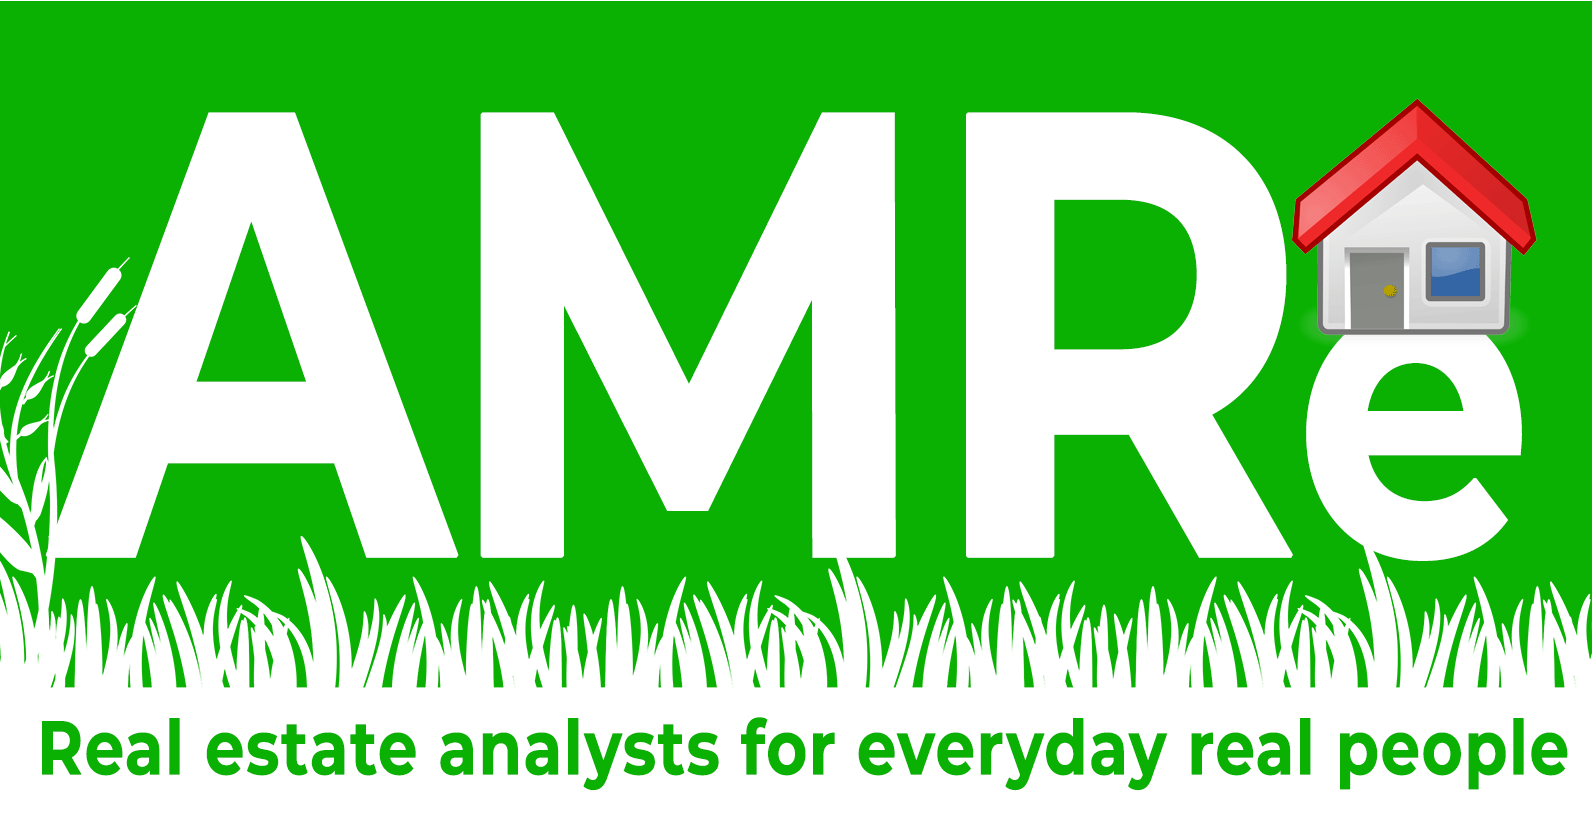

In [1]:
from IPython.display import Image
Image('images/logo.gif', width=200)

In [138]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as ss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.utils import check_array
from sklearn.utils.validation import check_array
import pmdarima as pm

In [139]:
# Data locations (Recall GIGO)
initialdata = 'data/Zip_ListingSale_Combined.csv' #https://www.zillow.com/research/data/
cleaneddata = 'data/Cleaned/Zip_ListingSale_Clean.csv' #https://www.zillow.com/research/data/
zipdata = 'data/us-zip-code-latitude-and-longitude.csv' #https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/
popdata = 'data/pop-by-zip-code.csv' #https://data.world/lukewhyte/us-population-by-zip-code-2010-2016
stormdata = 'data/storm_data_search_results.csv' #https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=12%2CFLORIDA
redata = 'data/real_estate_db.csv' #https://www.goldenoakresearch.com/product-page/real-estate-dataset
propertydata = 'data/arcgis/property_point_view_clean.csv' #from Adrian 
#schooldata

In [234]:
# Dataframes (Axiomatic)
list_sale_data = pd.read_csv(initialdata) #from Zillow
data_clean = pd.read_csv(cleaneddata) #cleaned data
data_zip = pd.read_csv(zipdata, sep=';') #zip code data with coordinates
pop_data = pd.read_csv(popdata) #population data
storm_data = pd.read_csv(stormdata) #tropical disturbance data
census_data = pd.read_csv(redata, encoding='latin1') #census data merged with real estate data
property_data = pd.read_csv(propertydata)

In [141]:
# Zip codes from Miguel for Miami-Dade and Broward County
MiamiDadeCounty_ZipCodes =  [
                            '33146','33145','33147','33150','33149','33154','33153','33156','33155','33158',
                            '33157','33160','33162','33161','33166','33165','33168','33167','33170','33169',
                            '33173','33172','33175','33174','33177','33176','33179','33178','33181','33180',
                            '33183','33182','33185','33184','33187','33186','33189','33188','33190','33194',
                            '33193','33196','33199','33242','33239','33106','33191','33206','33010','33013',
                            '33012','33015','33014','33016','33018','33027','33031','33030','33033','33032',
                            '33035','33034','33039','33055','33054','33056','33195','33090','33092','33101',
                            '33109','33112','33116','33114','33119','33122','33126','33125','33128','33127',
                            '33130','33129','33132','33131','33134','33133','33136','33135','33138','33137',
                            '33140','33139','33142','33141','33144','33143'
                            ]
BrowardCounty_ZipCodes =    [
                            '33302','33301','33304','33306','33305','33308','33310','33309','33312','33311',
                            '33314','33313','33316','33315','33318','33317','33319','33322','33321','33324',
                            '33323','33326','33325','33328','33327','33330','33329','33332','33331','33335',
                            '33334','33336','33338','33351','33394','33388','33004','33009','33008','33441',
                            '33442','33019','33021','33020','33023','33022','33025','33024','33026','33029',
                            '33028','33060','33062','33064','33063','33066','33065','33068','33067','33069',
                            '33071','33073','33076'
                            ]


# Initial Zillow Data Review and Cleaning

In [142]:
list_sale_data.rename(columns={'RegionName':'ZipCode'}, inplace=True)
list_sale_data[:5]

Type  ZipCode        City State                                  Metro  \
0  Listing    33009  Hallandale    FL  Miami-Fort Lauderdale-West Palm Beach   
1  Listing    33010     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
2  Listing    33012     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
3  Listing    33013     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
4  Listing    33014     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   

          CountyName  SizeRank   2010-01   2010-02   2010-03  ...   2018-12  \
0     Broward County       208  225500.0  239000.0  210000.0  ...  270000.0   
1  Miami-Dade County      2197       NaN       NaN       NaN  ...  309900.0   
2  Miami-Dade County       250       NaN       NaN       NaN  ...  264600.0   
3  Miami-Dade County      5078  180000.0  185000.0  177450.0  ...  339900.0   
4  Miami-Dade County      1996       NaN       NaN       NaN  ...  285000.0   

    2019-01   2019-02   2019-03   2019-04   2019-05   2019-06   2019-07  \
0  265000.0  265000.0  270000.0  274900.0  275000.0  273750.0  270000.0   
1  304950.0  320499.5  325000.0  310000.0  312500.0  315000.0  315000.0   
2  275000.0  285000.0  295767.5  281300.0  290000.0  299000.0  288950.0   
3  340000.0  345000.0  345000.0  350000.0  345000.0  344950.0  334500.0   
4  279750.0  299000.0  289375.0  299000.0  295000.0  296750.0  300000.0   

    2019-08   2019-09  
0  279000.0  279000.0  
1  299950.0  314830.0  
2  279900.0  280000.0  
3  330000.0  342000.0  
4  289700.0  289700.0  

[5 rows x 124 columns]

In [143]:
# Rotates table so dates are tuples rather than columns
df_list_sale = list_sale_data.melt(id_vars=["Type","ZipCode", "City", "State", "Metro", "CountyName", "SizeRank"], 
        var_name="Date", 
        value_name="Price")
df_list_sale[:5]

Type  ZipCode        City State                                  Metro  \
0  Listing    33009  Hallandale    FL  Miami-Fort Lauderdale-West Palm Beach   
1  Listing    33010     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
2  Listing    33012     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
3  Listing    33013     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
4  Listing    33014     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   

          CountyName  SizeRank     Date     Price  
0     Broward County       208  2010-01  225500.0  
1  Miami-Dade County      2197  2010-01       NaN  
2  Miami-Dade County       250  2010-01       NaN  
3  Miami-Dade County      5078  2010-01  180000.0  
4  Miami-Dade County      1996  2010-01       NaN

In [144]:
# Remove nulls
df_list_sale = df_list_sale[pd.notnull(df_list_sale['Price'])]
df_list_sale[:5]

Type  ZipCode        City State                                  Metro  \
0   Listing    33009  Hallandale    FL  Miami-Fort Lauderdale-West Palm Beach   
3   Listing    33013     Hialeah    FL  Miami-Fort Lauderdale-West Palm Beach   
8   Listing    33019   Hollywood    FL  Miami-Fort Lauderdale-West Palm Beach   
9   Listing    33020   Hollywood    FL  Miami-Fort Lauderdale-West Palm Beach   
11  Listing    33023     Miramar    FL  Miami-Fort Lauderdale-West Palm Beach   

           CountyName  SizeRank     Date     Price  
0      Broward County       208  2010-01  225500.0  
3   Miami-Dade County      5078  2010-01  180000.0  
8      Broward County      3881  2010-01  334894.5  
9      Broward County       847  2010-01  157100.0  
11     Broward County       641  2010-01  129950.0

In [145]:
df_pivot = df_list_sale.pivot_table(values=['Price'], index=['Date'], 
                              columns=['ZipCode', 'Type'])
df_pivot[:5]

Price                                                             \
ZipCode     33009        33010        33012          33013             33014   
Type      Listing Sale Listing Sale Listing Sale   Listing      Sale Listing   
Date                                                                           
2010-01  225500.0  NaN     NaN  NaN     NaN  NaN  180000.0  141000.0     NaN   
2010-02  239000.0  NaN     NaN  NaN     NaN  NaN  185000.0  148500.0     NaN   
2010-03  210000.0  NaN     NaN  NaN     NaN  NaN  177450.0  149900.0     NaN   
2010-04  199900.0  NaN     NaN  NaN     NaN  NaN  198000.0  150200.0     NaN   
2010-05  209000.0  NaN     NaN  NaN     NaN  NaN  180000.0  140300.0     NaN   

              ...                                                          \
ZipCode       ...   33483        33484          33486               33487   
Type    Sale  ... Listing Sale Listing Sale   Listing      Sale   Listing   
Date          ...                                                           
2010-01  NaN  ...     NaN  NaN     NaN  NaN  348000.0  244000.0  495000.0   
2010-02  NaN  ...     NaN  NaN     NaN  NaN  350000.0  239200.0  489000.0   
2010-03  NaN  ...     NaN  NaN     NaN  NaN  349000.0  250000.0  485000.0   
2010-04  NaN  ...     NaN  NaN     NaN  NaN  349900.0  253500.0  440000.0   
2010-05  NaN  ...     NaN  NaN     NaN  NaN  342700.0  278900.0  435000.0   

                                       
ZipCode               33498            
Type         Sale   Listing      Sale  
Date                                   
2010-01  288300.0  394944.0  308700.0  
2010-02  353100.0  372000.0  302700.0  
2010-03  354100.0  354999.0  297600.0  
2010-04  363200.0  354999.0  310700.0  
2010-05  295500.0  349949.5  313500.0  

[5 rows x 270 columns]

In [146]:
# Export to CSV
# df_list_sale.to_csv('data/Zip_ListingSale_Combined_Clean.csv')

In [147]:
# Import cleaned data
data_clean[:5]

Date  ZipCode            City State  \
0  2010-01    33019       Hollywood    FL   
1  2010-01    33023         Miramar    FL   
2  2010-01    33024  Pembroke Pines    FL   
3  2010-01    33028  Pembroke Pines    FL   
4  2010-01    33029  Pembroke Pines    FL   

                                   Metro          County   Listing    Sale  
0  Miami-Fort Lauderdale-West Palm Beach  Broward County  334894.5  191400  
1  Miami-Fort Lauderdale-West Palm Beach  Broward County  129950.0   89600  
2  Miami-Fort Lauderdale-West Palm Beach  Broward County  159900.0  121000  
3  Miami-Fort Lauderdale-West Palm Beach  Broward County  320000.0  280300  
4  Miami-Fort Lauderdale-West Palm Beach  Broward County  335000.0  270300

In [148]:
data_zip = data_zip.rename(columns={"Zip": "ZipCode"})
data_zip

ZipCode               City State   Latitude  Longitude  Timezone  \
0       33446       Delray Beach    FL  26.452473 -80.165090        -5   
1       32621            Bronson    FL  29.447069 -82.604520        -5   
2       34447  Homosassa Springs    FL  28.804911 -82.574264        -5   
3       34489     Silver Springs    FL  29.215153 -82.097163        -5   
4       32503          Pensacola    FL  30.447997 -87.207270        -6   
...       ...                ...   ...        ...        ...       ...   
1503    34753           Mascotte    FL  28.583191 -81.890380        -5   
1504    34691            Holiday    FL  28.190060 -82.757350        -5   
1505    33849           Kathleen    FL  28.246250 -82.063580        -5   
1506    32597          Pensacola    FL  30.529739 -87.275693        -6   
1507    33464         Lake Worth    FL  26.645895 -80.430269        -5   

      Daylight savings time flag              geopoint  
0                              1   26.452473,-80.16509  
1                              1   29.447069,-82.60452  
2                              1  28.804911,-82.574264  
3                              1  29.215153,-82.097163  
4                              1   30.447997,-87.20727  
...                          ...                   ...  
1503                           1   28.583191,-81.89038  
1504                           1    28.19006,-82.75735  
1505                           1    28.24625,-82.06358  
1506                           1  30.529739,-87.275693  
1507                           1  26.645895,-80.430269  

[1508 rows x 8 columns]

In [149]:
data_clean = data_clean.merge(data_zip, on='ZipCode', how='left')
data_clean = data_clean.drop(['City_y', 'State_y'], axis=1)
data_clean.head()

Date  ZipCode          City_x State_x  \
0  2010-01    33019       Hollywood      FL   
1  2010-01    33023         Miramar      FL   
2  2010-01    33024  Pembroke Pines      FL   
3  2010-01    33028  Pembroke Pines      FL   
4  2010-01    33029  Pembroke Pines      FL   

                                   Metro          County   Listing    Sale  \
0  Miami-Fort Lauderdale-West Palm Beach  Broward County  334894.5  191400   
1  Miami-Fort Lauderdale-West Palm Beach  Broward County  129950.0   89600   
2  Miami-Fort Lauderdale-West Palm Beach  Broward County  159900.0  121000   
3  Miami-Fort Lauderdale-West Palm Beach  Broward County  320000.0  280300   
4  Miami-Fort Lauderdale-West Palm Beach  Broward County  335000.0  270300   

    Latitude  Longitude  Timezone  Daylight savings time flag  \
0  26.018967  -80.12231        -5                           1   
1  25.989119  -80.21318        -5                           1   
2  26.023567  -80.23851        -5                           1   
3  26.018418  -80.34798        -5                           1   
4  26.006373  -80.40212        -5                           1   

              geopoint  
0  26.018967,-80.12231  
1  25.989119,-80.21318  
2  26.023567,-80.23851  
3  26.018418,-80.34798  
4  26.006373,-80.40212

In [150]:
data_clean = data_clean.rename(columns={'City_x': 'City', 'State_x': 'State'})
data_clean.head()

Date  ZipCode            City State  \
0  2010-01    33019       Hollywood    FL   
1  2010-01    33023         Miramar    FL   
2  2010-01    33024  Pembroke Pines    FL   
3  2010-01    33028  Pembroke Pines    FL   
4  2010-01    33029  Pembroke Pines    FL   

                                   Metro          County   Listing    Sale  \
0  Miami-Fort Lauderdale-West Palm Beach  Broward County  334894.5  191400   
1  Miami-Fort Lauderdale-West Palm Beach  Broward County  129950.0   89600   
2  Miami-Fort Lauderdale-West Palm Beach  Broward County  159900.0  121000   
3  Miami-Fort Lauderdale-West Palm Beach  Broward County  320000.0  280300   
4  Miami-Fort Lauderdale-West Palm Beach  Broward County  335000.0  270300   

    Latitude  Longitude  Timezone  Daylight savings time flag  \
0  26.018967  -80.12231        -5                           1   
1  25.989119  -80.21318        -5                           1   
2  26.023567  -80.23851        -5                           1   
3  26.018418  -80.34798        -5                           1   
4  26.006373  -80.40212        -5                           1   

              geopoint  
0  26.018967,-80.12231  
1  25.989119,-80.21318  
2  26.023567,-80.23851  
3  26.018418,-80.34798  
4  26.006373,-80.40212

In [151]:
#data_clean.to_csv('data/data_with_zip.csv')

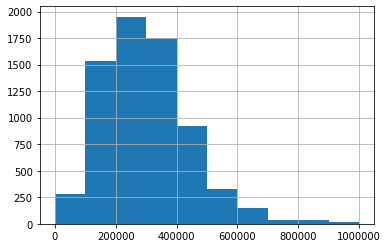

In [152]:
data_clean["Listing"].hist(bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, 700000,
                                 800000, 900000, 1000000])

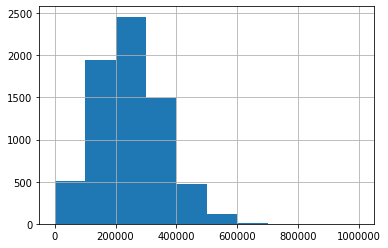

In [153]:
data_clean["Sale"].hist(bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, 700000,
                                 800000, 900000, 1000000])

In [154]:
data_clean["Date"] = pd.to_datetime(data_clean["Date"], format="%Y-%m")
data_clean.dtypes

Date                          datetime64[ns]
ZipCode                                int64
City                                  object
State                                 object
Metro                                 object
County                                object
Listing                              float64
Sale                                   int64
Latitude                             float64
Longitude                            float64
Timezone                               int64
Daylight savings time flag             int64
geopoint                              object
dtype: object

In [155]:
data_clean[:5]

Date  ZipCode            City State  \
0 2010-01-01    33019       Hollywood    FL   
1 2010-01-01    33023         Miramar    FL   
2 2010-01-01    33024  Pembroke Pines    FL   
3 2010-01-01    33028  Pembroke Pines    FL   
4 2010-01-01    33029  Pembroke Pines    FL   

                                   Metro          County   Listing    Sale  \
0  Miami-Fort Lauderdale-West Palm Beach  Broward County  334894.5  191400   
1  Miami-Fort Lauderdale-West Palm Beach  Broward County  129950.0   89600   
2  Miami-Fort Lauderdale-West Palm Beach  Broward County  159900.0  121000   
3  Miami-Fort Lauderdale-West Palm Beach  Broward County  320000.0  280300   
4  Miami-Fort Lauderdale-West Palm Beach  Broward County  335000.0  270300   

    Latitude  Longitude  Timezone  Daylight savings time flag  \
0  26.018967  -80.12231        -5                           1   
1  25.989119  -80.21318        -5                           1   
2  26.023567  -80.23851        -5                           1   
3  26.018418  -80.34798        -5                           1   
4  26.006373  -80.40212        -5                           1   

              geopoint  
0  26.018967,-80.12231  
1  25.989119,-80.21318  
2  26.023567,-80.23851  
3  26.018418,-80.34798  
4  26.006373,-80.40212

In [156]:
# Correlation between sales and listings
data_clean['Sale'].corr(data_clean['Listing'])

0.9409870546141571

As expected, there is a strong positive correlation between median Sale price and median Listing price. A weak correlation would signify that we should analyze both independently.

# Compartmentalize Data by Year

In [157]:
data_2019 = data_clean[(data_clean['Date'] > '2019-01') & (data_clean['Date'] < '2020-1')]
data_2018 = data_clean[(data_clean['Date'] > '2018-01') & (data_clean['Date'] < '2019-1')]
data_2017 = data_clean[(data_clean['Date'] > '2017-01') & (data_clean['Date'] < '2018-1')]
data_2016 = data_clean[(data_clean['Date'] > '2016-01') & (data_clean['Date'] < '2017-1')]
data_2015 = data_clean[(data_clean['Date'] > '2015-01') & (data_clean['Date'] < '2016-1')]
data_2014 = data_clean[(data_clean['Date'] > '2014-01') & (data_clean['Date'] < '2015-1')]
data_2013 = data_clean[(data_clean['Date'] > '2013-01') & (data_clean['Date'] < '2014-1')]
data_2012 = data_clean[(data_clean['Date'] > '2012-01') & (data_clean['Date'] < '2013-1')]
data_2011 = data_clean[(data_clean['Date'] > '2011-01') & (data_clean['Date'] < '2012-1')]
data_2010 = data_clean[(data_clean['Date'] > '2010-01') & (data_clean['Date'] < '2011-1')]

In [158]:
data_2010.head()

Date  ZipCode            City State  \
14 2010-02-01    33019       Hollywood    FL   
15 2010-02-01    33023         Miramar    FL   
16 2010-02-01    33024  Pembroke Pines    FL   
17 2010-02-01    33028  Pembroke Pines    FL   
18 2010-02-01    33029  Pembroke Pines    FL   

                                    Metro          County   Listing    Sale  \
14  Miami-Fort Lauderdale-West Palm Beach  Broward County  335000.0  196900   
15  Miami-Fort Lauderdale-West Palm Beach  Broward County  139700.0   84800   
16  Miami-Fort Lauderdale-West Palm Beach  Broward County  164900.0  121300   
17  Miami-Fort Lauderdale-West Palm Beach  Broward County  319456.5  289400   
18  Miami-Fort Lauderdale-West Palm Beach  Broward County  340000.0  272200   

     Latitude  Longitude  Timezone  Daylight savings time flag  \
14  26.018967  -80.12231        -5                           1   
15  25.989119  -80.21318        -5                           1   
16  26.023567  -80.23851        -5                           1   
17  26.018418  -80.34798        -5                           1   
18  26.006373  -80.40212        -5                           1   

               geopoint  
14  26.018967,-80.12231  
15  25.989119,-80.21318  
16  26.023567,-80.23851  
17  26.018418,-80.34798  
18  26.006373,-80.40212

In [159]:
data_2018.describe()

ZipCode        Listing           Sale     Latitude    Longitude  \
count   1042.000000    1042.000000    1042.000000  1042.000000  1042.000000   
mean   33153.336852  343456.046545  279154.126679    25.937945   -80.269255   
std      105.677235  144581.359267   98765.697702     0.213731     0.096856   
min    33009.000000  100000.000000   95200.000000    25.431506   -80.513820   
25%    33063.000000  245000.000000  205625.000000    25.763044   -80.348590   
50%    33145.000000  321975.000000  265800.000000    25.942670   -80.263100   
75%    33189.000000  414937.500000  337600.000000    26.112924   -80.189300   
max    33442.000000  999000.000000  645800.000000    26.309757   -80.095940   

       Timezone  Daylight savings time flag  
count    1042.0                      1042.0  
mean       -5.0                         1.0  
std         0.0                         0.0  
min        -5.0                         1.0  
25%        -5.0                         1.0  
50%        -5.0                         1.0  
75%        -5.0                         1.0  
max        -5.0                         1.0

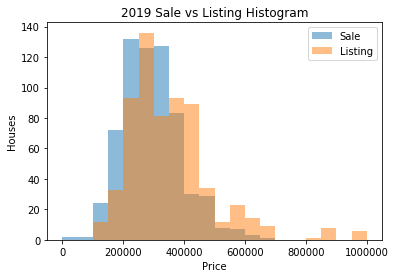

In [160]:
# Sale vs. Listing Histogram - 2019
bins=[0, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 
      600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]
plt.hist(data_2019["Sale"], bins, alpha=0.5, label='Sale')
plt.hist(data_2019["Listing"], bins, alpha=0.5, label='Listing')
plt.legend(loc='upper right')
plt.title('2019 Sale vs Listing Histogram')
plt.xlabel('Price')
plt.ylabel('Houses')
plt.show()

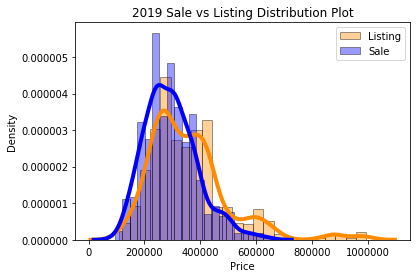

In [161]:
# Density Plot - 2019
sns.distplot(data_2019["Listing"], hist=True, kde=True, 
             color = 'darkorange', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Listing')
sns.distplot(data_2019["Sale"], hist=True, kde=True, 
             color = 'blue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Sale')
plt.title('2019 Sale vs Listing Distribution Plot')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

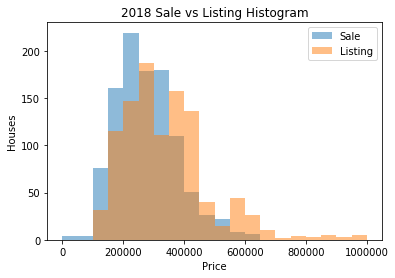

In [162]:
# 2018
plt.hist(data_2018["Sale"], bins, alpha=0.5, label='Sale')
plt.hist(data_2018["Listing"], bins, alpha=0.5, label='Listing')
plt.legend(loc='upper right')
plt.title('2018 Sale vs Listing Histogram')
plt.xlabel('Price')
plt.ylabel('Houses')
plt.show()

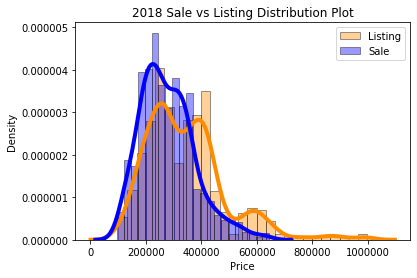

In [163]:
# 2018
sns.distplot(data_2018["Listing"], hist=True, kde=True, 
             color = 'darkorange', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Listing')
sns.distplot(data_2018["Sale"], hist=True, kde=True, 
             color = 'blue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Sale')
plt.title('2018 Sale vs Listing Distribution Plot')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

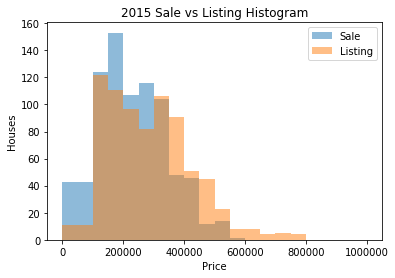

In [164]:
# 2015
plt.hist(data_2015["Sale"], bins, alpha=0.5, label='Sale')
plt.hist(data_2015["Listing"], bins, alpha=0.5, label='Listing')
plt.legend(loc='upper right')
plt.title('2015 Sale vs Listing Histogram')
plt.xlabel('Price')
plt.ylabel('Houses')
plt.show()

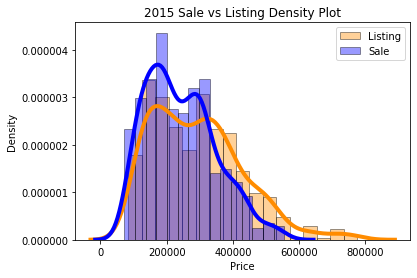

In [165]:
# 2015
sns.distplot(data_2015["Listing"], hist=True, kde=True, 
             color = 'darkorange', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Listing')
sns.distplot(data_2015["Sale"], hist=True, kde=True, 
             color = 'blue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, label='Sale')
plt.title('2015 Sale vs Listing Density Plot')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

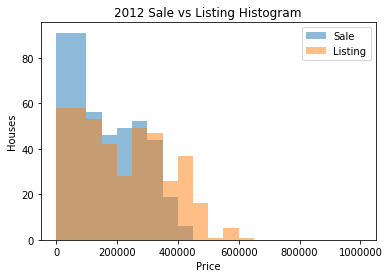

In [166]:
# 2012
plt.hist(data_2012["Sale"], bins, alpha=0.5, label='Sale')
plt.hist(data_2012["Listing"], bins, alpha=0.5, label='Listing')
plt.legend(loc='upper right')
plt.title('2012 Sale vs Listing Histogram')
plt.xlabel('Price')
plt.ylabel('Houses')
plt.show()

In [167]:
# 2012
sns.distplot(data_2013["Listing"], hist=True, kde=True, 
             color = 'darkorange', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(data_2013["Sale"], hist=True, kde=True, 
             color = 'blue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('2013 Sale vs Listing Density Plot')
plt.xlabel('Price')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

Note: Extremely low demand and relatively high supply any given year for houses in the 400k-500k range. 
Suggests easier time selling a house greater than 400k or less than 500k.

# Miami-Dade Listing vs Sale Time Series

In [168]:
# Miami-Dade
data_clean_miami = data_clean[data_clean['County'].str.contains('Miami')]
data_clean_miami = data_clean_miami.groupby(['Date'])['Listing', 'Sale'].median().reset_index()
data_clean_miami[:5]

Date   Listing    Sale
0 2010-01-01  216250.0  162000
1 2010-02-01  214900.0  159400
2 2010-03-01  209950.0  169100
3 2010-04-01  199900.0  167400
4 2010-05-01  199000.0  170200

Text(0, 0.5, 'Price')

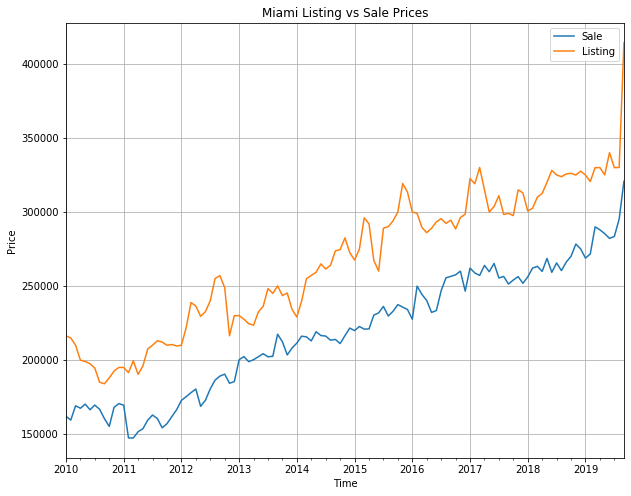

In [169]:
# Miami-Dade
data_clean_miami[['Date','Sale','Listing']].plot('Date', figsize=(10,8), grid=True, 
                                                 title="Miami Listing vs Sale Prices")
plt.xlabel('Time')
plt.ylabel('Price')

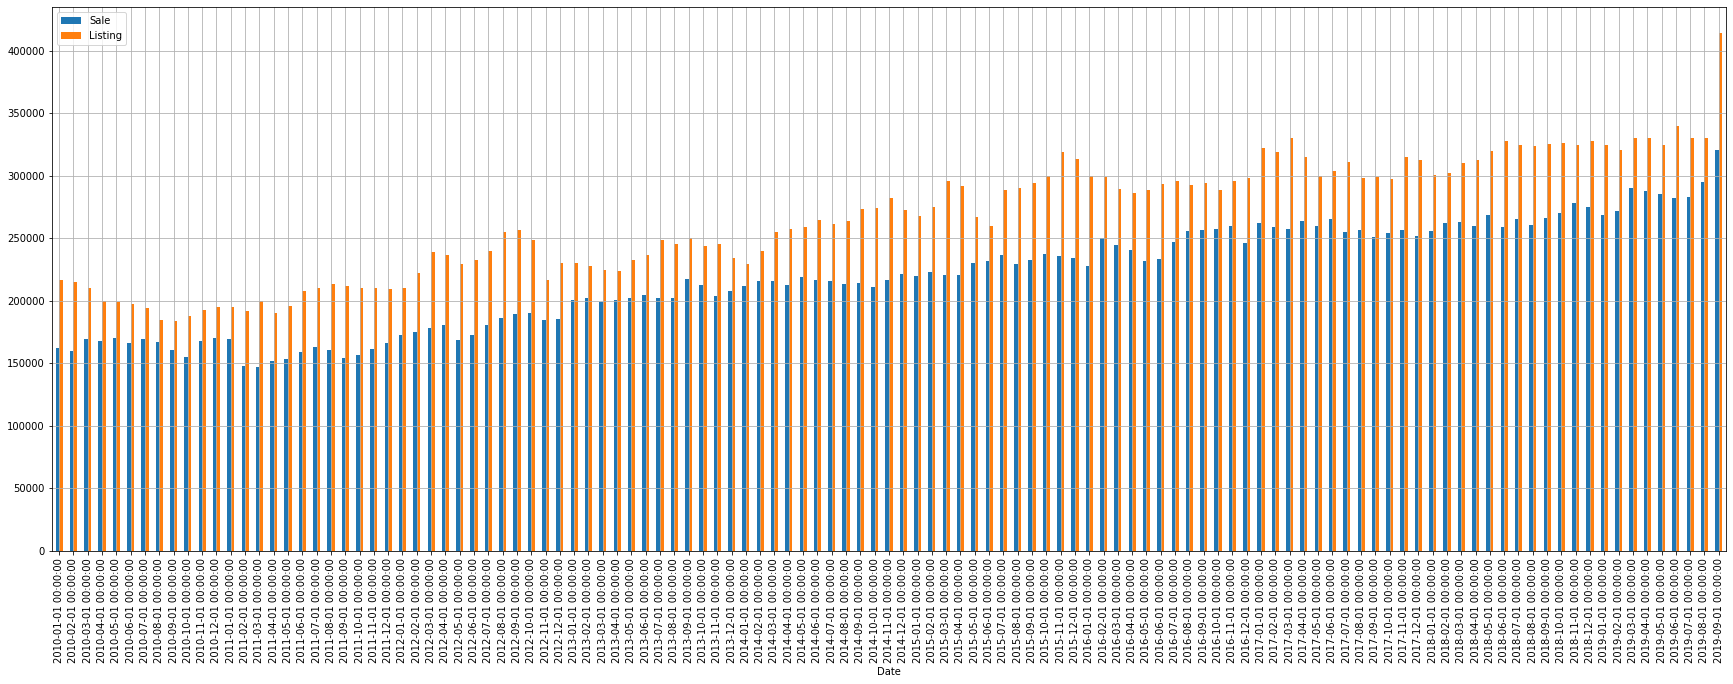

In [170]:
# Miami-Dade
data_clean_miami[['Date','Sale', 'Listing']].plot('Date', figsize=(30,10), kind='bar', grid=True)

# Predict price changes within Zip Code using ARIMA

In [259]:
zipcode = 33196
data_zip = data_clean.loc[(data_clean['ZipCode'] == zipcode), ['Date', 'Listing']]
data_zip = data_zip.set_index('Date')
data_zip.head()

Listing
Date          
2012  236557.5
2012  230000.0
2012  229000.0
2012  225307.5
2012  230480.0

In [260]:
#data_listing = data_clean[['Listing']]
#data_listing['Date'] = pd.to_datetime(data_listing.Date, format='%Y-%m')
#data_listing.head()

In [261]:
result = adfuller(data_zip.Listing)
print('ADF: %f' % result[0])
print('p-value: %f' % result[1])

ADF: -0.483456
p-value: 0.895205


Data is non-stationary as expected.

In [262]:
# ARIMA Model - Create Training and Test
#train = data_zip[:60]
#test = data_zip[60:]

Used training data to find appropriate ARIMA model, and settled on using whole set to train once I had the model.

In [263]:
# SARIMA
model = SARIMAX(data_zip, order=(1,0,1), seasonal_order=(1,1,0,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            Listing   No. Observations:                   91
Model:             SARIMAX(1, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -695.761
Date:                            Wed, 04 Dec 2019   AIC                           1399.522
Time:                                    17:03:03   BIC                           1408.281
Sample:                                         0   HQIC                          1402.983
                                             - 91                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9773      0.045     21.956      0.000       0.890       1.065
ma.L1         -0.0309      0.245   

/Users/rogerjimenez/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


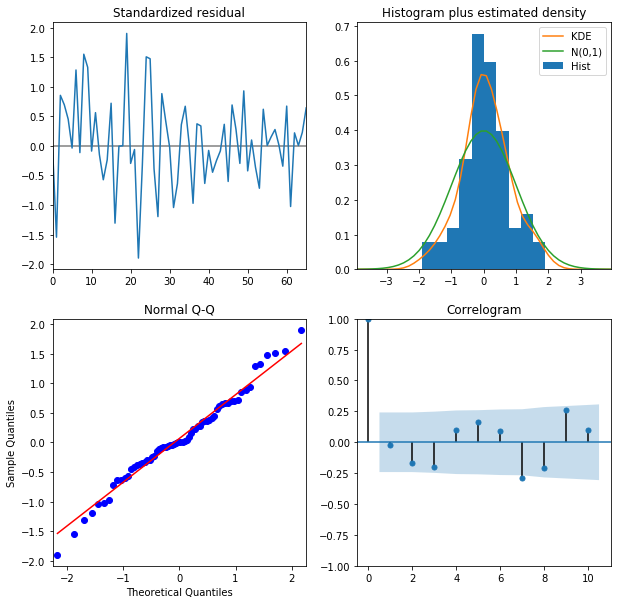

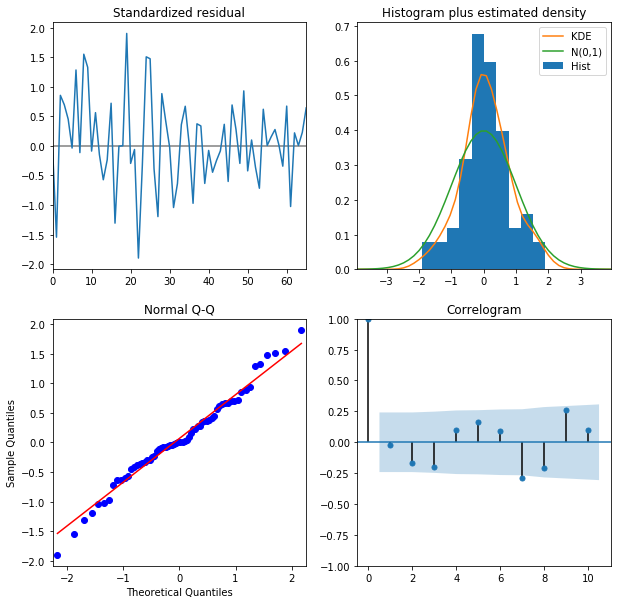

In [264]:
results.plot_diagnostics(figsize=(10,10))

In [265]:
prediction = results.get_prediction(start = 0, end = 80, dynamic=False)
prediction_ci = prediction.conf_int()

In [266]:
forecast = prediction.predicted_mean
forecast = forecast[61:]
forecast

Date
2017    344621.800603
2017    330698.530076
2017    332668.240226
2017    346185.331089
2017    339564.787482
2017    343947.046932
2017    342791.062615
2017    346015.336028
2017    340865.024219
2018    346332.326538
2018    331940.345596
2018    341769.126638
2018    348377.930911
2018    347309.671012
2018    356577.939487
2018    353839.889602
2018    359126.765579
2018    358201.548525
2018    351871.799311
2018    358899.013656
dtype: float64

In [267]:
forecast = forecast.reset_index()
forecast.columns = ['Date', 'Mean']
forecast = forecast['Mean']
forecast

0     344621.800603
1     330698.530076
2     332668.240226
3     346185.331089
4     339564.787482
5     343947.046932
6     342791.062615
7     346015.336028
8     340865.024219
9     346332.326538
10    331940.345596
11    341769.126638
12    348377.930911
13    347309.671012
14    356577.939487
15    353839.889602
16    359126.765579
17    358201.548525
18    351871.799311
19    358899.013656
Name: Mean, dtype: float64

In [268]:
true = data_zip[61:]
true

Listing
Date          
2017  333499.5
2017  335000.0
2017  336560.0
2017  338920.0
2017  338700.0
2017  338850.0
2017  339955.0
2017  345070.0
2017  345070.0
2018  339450.0
2018  339900.0
2018  345000.0
2018  345000.0
2018  358000.0
2018  351750.0
2018  355000.0
2018  355000.0
2018  350000.0
2018  359000.0
2018  359000.0
2018  358000.0
2019  360000.0
2019  359838.5
2019  360000.0
2019  364900.0
2019  360000.0
2019  359999.0
2019  362500.0
2019  364683.0
2019  369000.0

In [269]:
true = true.reset_index()
true = true['Listing']
true = true[:20]

In [270]:
true

0     333499.5
1     335000.0
2     336560.0
3     338920.0
4     338700.0
5     338850.0
6     339955.0
7     345070.0
8     345070.0
9     339450.0
10    339900.0
11    345000.0
12    345000.0
13    358000.0
14    351750.0
15    355000.0
16    355000.0
17    350000.0
18    359000.0
19    359000.0
Name: Listing, dtype: float64

In [271]:
# Compute the mean square error and root MSE
mse = ((forecast - true) ** 2).mean()
print('Mean Squared Error (MSE): {}'.format(round(mse, 2)))
print('Root Mean Square Error (RMSE): {:.4f}'
      .format(np.sqrt(sum((forecast-true)**2)/len(forecast))))

# Compute MAPE; source: https://stackoverflow.com/questions/47648133/mape-calculation-in-python
# Comment out if divide by zero error (weakness of MAPE and MPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(true, forecast)

print('Mean Absolute Percentage Error (MAPE): {}'.format(round(mape, 2)))

def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

mpe = mean_percentage_error(true, forecast)

print('Mean Percentage Error (MPE): {}'.format(round(mpe, 2)))

# Compute mean absolute error (MAE)
mae = mean_absolute_error(true, forecast)
print('Mean Absolute Error (MAE): {}'.format(round(mae, 2)))

# Mean Error
me = np.mean(true - forecast)
print('Mean Error (ME): {}'.format(round(me, 2)))

# Min-Max Accuracy (Source: https://adataanalyst.com/machine-learning/guide-for-linear-regression-using-python-part-2/)
# minmax = min(true, hourly_forecast)/max(true, hourly_forecast)
minmax = np.mean(min(min(true),min(forecast)) / max(max(true),max(forecast)))
print('Min-Max Accuracy (min-max): {}'.format(round(minmax, 3)))

# Correlation Prediction vs Actual
corr = true.corr(forecast)
print('Correlation between prediction and actual: {}'.format(round(corr, 2)))

Mean Squared Error (MSE): 33505601.19
Root Mean Square Error (RMSE): 5788.4023
Mean Absolute Percentage Error (MAPE): 1.42
Mean Percentage Error (MPE): -0.2
Mean Absolute Error (MAE): 4910.79
Mean Error (ME): -643.95
Min-Max Accuracy (min-max): 0.921
Correlation between prediction and actual: 0.76


In [272]:
# Get forecast of next n months
forecast = results.get_forecast(steps=25)

# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

/Users/rogerjimenez/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


lower Listing  upper Listing
91  351101.824481  396006.014103
92  344485.780851  406312.447046
93  337103.259936  411585.243403
94  329883.684206  414707.721702
95  325101.558460  418742.740136

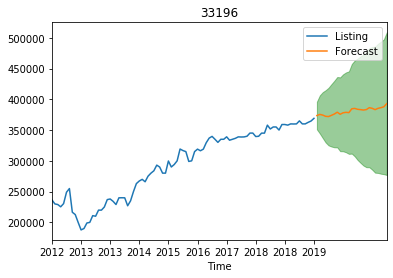

In [273]:
ax = data_zip.plot(label='Actual')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time')
ax.set_ylabel('')

plt.title(zipcode)
plt.legend()
plt.show()

# Difference between sales and listings

In [186]:
# Miami-Dade
data_clean_miami['PercRedux'] = (data_clean_miami['Listing']-data_clean_miami['Sale'])\
    /data_clean_miami['Listing']
data_clean_miami.PercRedux = (data_clean_miami.PercRedux * 100).round()
data_clean_miami[:5]

Date   Listing    Sale  PercRedux
0 2010-01-01  216250.0  162000       25.0
1 2010-02-01  214900.0  159400       26.0
2 2010-03-01  209950.0  169100       19.0
3 2010-04-01  199900.0  167400       16.0
4 2010-05-01  199000.0  170200       14.0

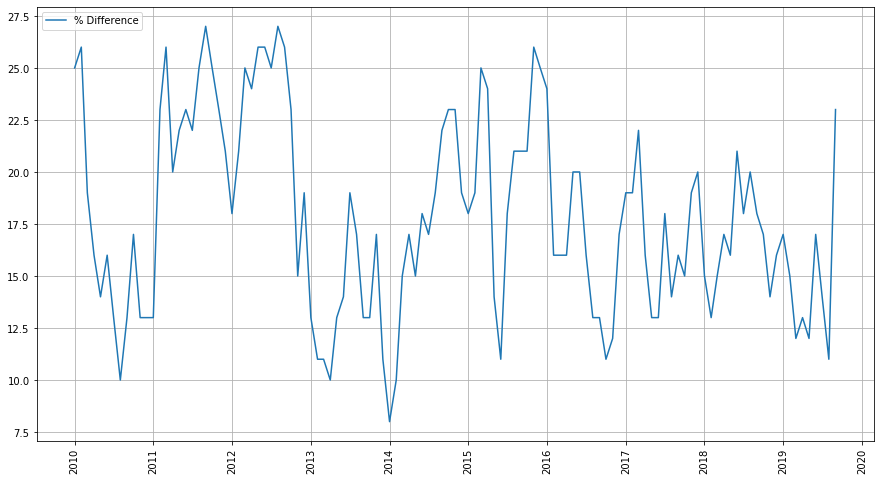

In [187]:
# Miami-Dade
plt.figure(figsize = (15, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(data_clean_miami.Date, data_clean_miami.PercRedux)
plt.legend(['% Difference'], loc='upper left')

In [188]:
# Adding zip codes for later analysis
data_clean_miami_zip = data_clean[data_clean['County'].str.contains('Miami')]
data_clean_miami_zip = data_clean_miami_zip.groupby(['Date', 'ZipCode'])['Listing', 'Sale'].median().reset_index()
data_clean_miami_zip[:5]

Date  ZipCode   Listing    Sale
0 2010-01-01    33013  180000.0  141000
1 2010-01-01    33054   99400.0   43200
2 2010-01-01    33055  132500.0   85100
3 2010-01-01    33165  238600.0  162000
4 2010-01-01    33180  349000.0  241800

Text(0, 0.5, 'Density')

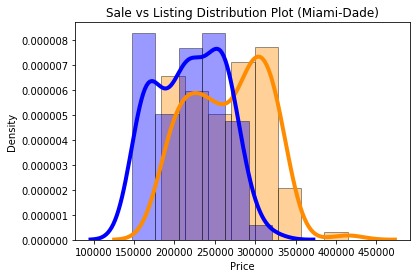

In [189]:
sns.distplot(data_clean_miami["Listing"], hist=True, kde=True, 
             color = 'darkorange', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(data_clean_miami["Sale"], hist=True, kde=True, 
             color = 'blue', hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.title('Sale vs Listing Distribution Plot (Miami-Dade)')
plt.xlabel('Price')
plt.ylabel('Density')

In [190]:
result = adfuller(data_clean_miami.PercRedux)
print('ADF: %f' % result[0])
print('p-value: %f' % result[1])

ADF: -4.428987
p-value: 0.000264


In [191]:
data_clean_miami

Date    Listing    Sale  PercRedux
0   2010-01-01  216250.00  162000       25.0
1   2010-02-01  214900.00  159400       26.0
2   2010-03-01  209950.00  169100       19.0
3   2010-04-01  199900.00  167400       16.0
4   2010-05-01  199000.00  170200       14.0
..         ...        ...     ...        ...
112 2019-05-01  325000.00  285300       12.0
113 2019-06-01  340000.00  282100       17.0
114 2019-07-01  329900.00  283400       14.0
115 2019-08-01  330000.00  295100       11.0
116 2019-09-01  414271.25  320750       23.0

[117 rows x 4 columns]

In [192]:
# Create Training and Test
train = data_clean_miami.PercRedux[:85]
test = data_clean_miami.PercRedux[85:]

In [193]:
dfMiamiRedux = data_clean_miami[['Date', 'PercRedux']]
dfMiamiRedux = dfMiamiRedux.set_index('Date')
dfMiamiRedux.head()

PercRedux
Date                 
2010-01-01       25.0
2010-02-01       26.0
2010-03-01       19.0
2010-04-01       16.0
2010-05-01       14.0

In [194]:
model = SARIMAX(dfMiamiRedux, order=(1,0,1), seasonal_order=(1,1,0,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          PercRedux   No. Observations:                  117
Model:             SARIMAX(1, 0, 1)x(1, 1, 0, 12)   Log Likelihood                -256.073
Date:                            Wed, 04 Dec 2019   AIC                            520.147
Time:                                    15:30:26   BIC                            530.234
Sample:                                01-01-2010   HQIC                           524.218
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6780      0.099      6.877      0.000       0.485       0.871
ma.L1          0.2296      0.133   

/Users/rogerjimenez/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [195]:
prediction = results.get_prediction(start = 0, end = 117, dynamic=False)
prediction_ci = prediction.conf_int()

In [196]:
# Get forecast of next n months
forecast = results.get_forecast(steps= 50)

# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

lower PercRedux  upper PercRedux
2019-10-01        14.774755        30.113668
2019-11-01        10.745209        31.460379
2019-12-01         9.760915        32.525651
2020-01-01         6.134560        29.782039
2020-02-01         3.282955        27.325396

In [197]:
ax = dfMiamiRedux.plot(figsize=(30,8))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time')
ax.set_ylabel('% Reduced')

plt.legend()
plt.show()

Note: Seasonal trend. Difference between median sale price and median listing price drops in the beginning of the year (suggests higher demand), and regularly peaks between summer and fall months suggesting that is the best

# Broward Listing vs Sale Time Series

In [198]:
# Broward
data_clean_broward = data_clean[data_clean['County'].str.contains('Broward')]
data_clean_broward = data_clean_broward.groupby(['Date'])['Listing', 'Sale'].median().reset_index()
data_clean_broward['PercRedux'] = (data_clean_broward['Listing']-data_clean_broward['Sale'])\
    /data_clean_broward['Listing']
data_clean_broward.PercRedux = (data_clean_broward.PercRedux * 100).round()
data_clean_broward[:5]

Date    Listing    Sale  PercRedux
0 2010-01-01  297450.00  190000       36.0
1 2010-02-01  293728.25  204400       30.0
2 2010-03-01  279999.75  203150       27.0
3 2010-04-01  290088.50  206750       29.0
4 2010-05-01  283749.75  184650       35.0

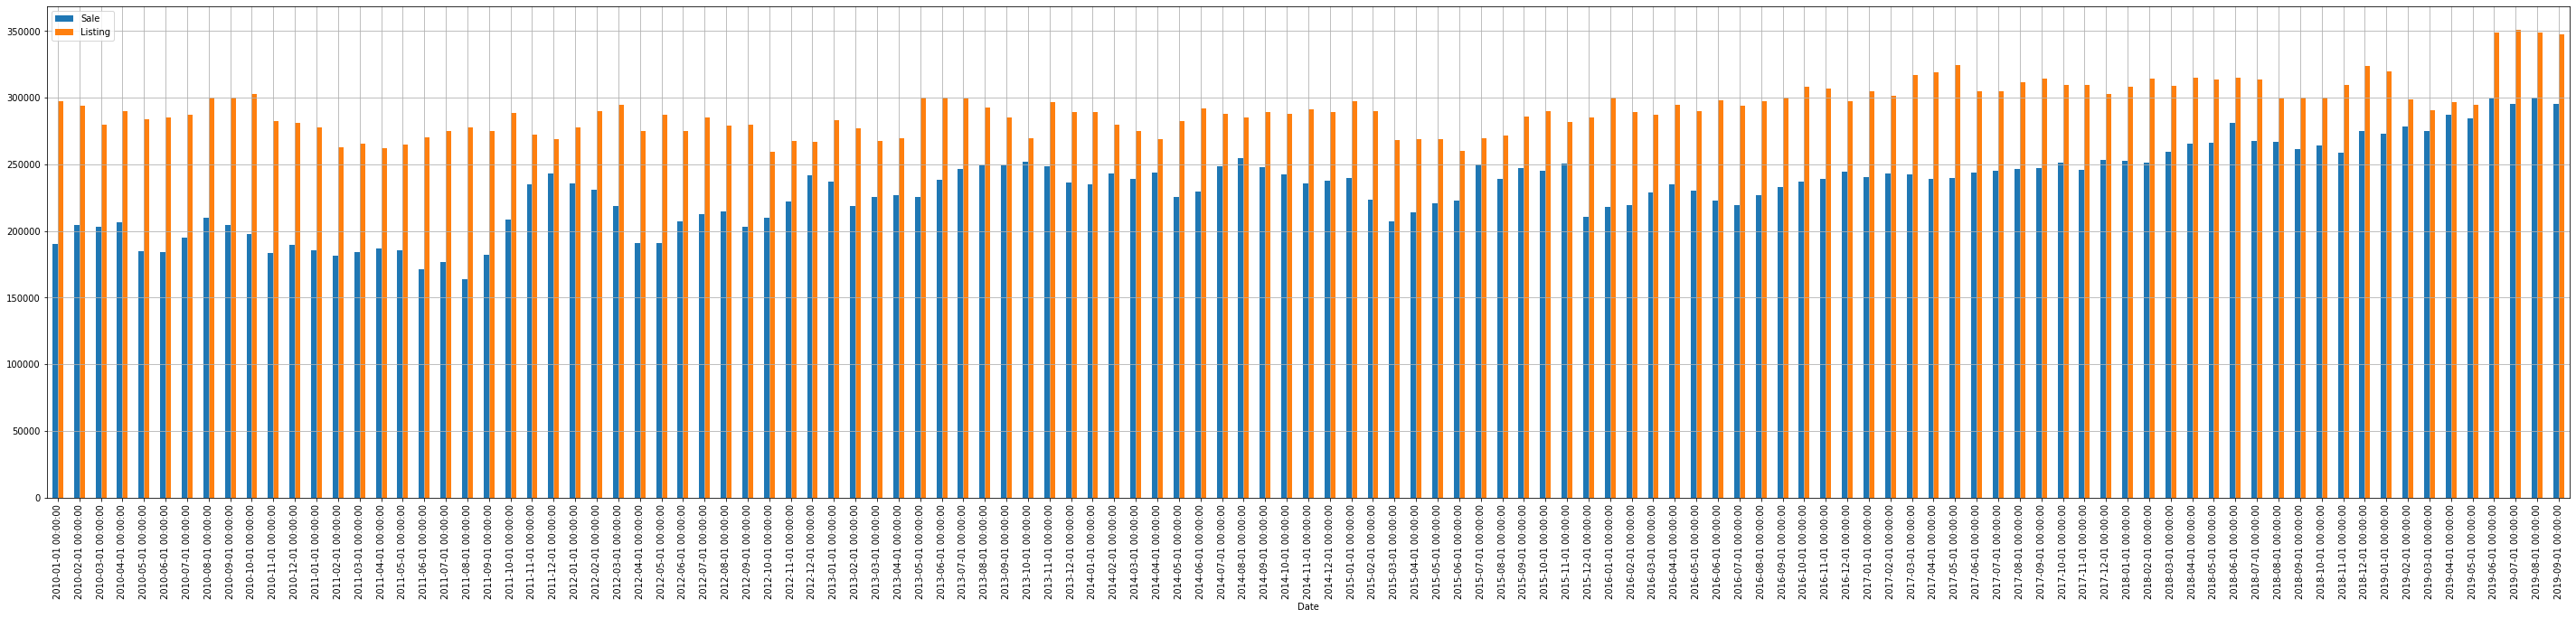

In [199]:
# Broward
data_clean_broward[['Date','Sale', 'Listing']].plot('Date', figsize=(50,10), kind='bar', grid=True)

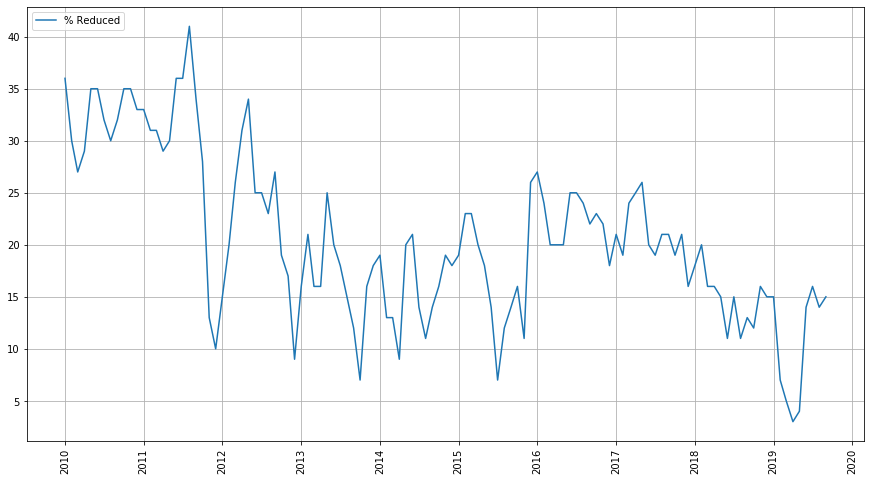

In [200]:
# Broward
plt.figure(figsize = (15, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(data_clean_broward.Date, data_clean_broward.PercRedux)
plt.legend(['% Reduced'], loc='upper left')

In [201]:
data_clean_miami.PercRedux.corr(data_clean_broward.PercRedux)

0.2697101286290812

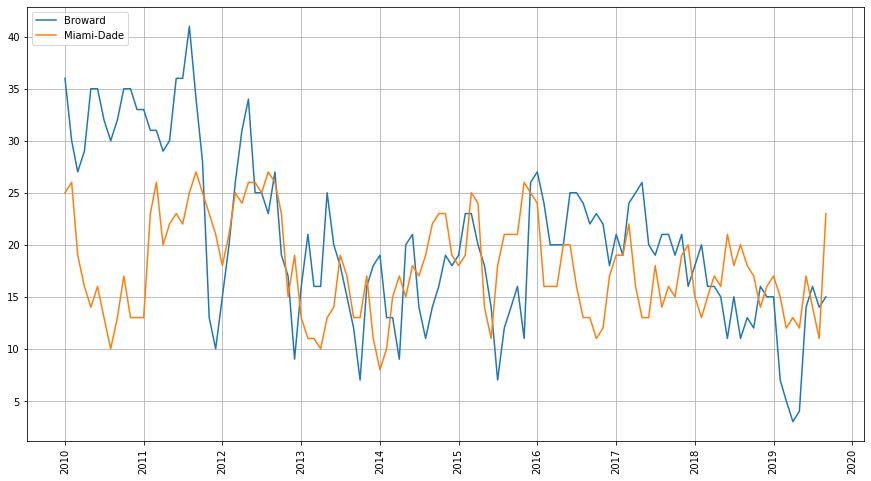

In [202]:
# Miami-Dade and Broward County
plt.figure(figsize = (15, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(data_clean_broward.Date, data_clean_broward.PercRedux)
plt.plot(data_clean_miami.Date, data_clean_miami.PercRedux)
plt.legend(['Broward', 'Miami-Dade'], loc='upper left')

In [203]:
# Adding zip codes for later analysis
data_clean_broward_zip = data_clean[data_clean['County'].str.contains('Broward')]
data_clean_broward_zip = data_clean_broward_zip.groupby(['Date', 'ZipCode'])['Listing', 'Sale'].median().reset_index()
data_clean_broward_zip[:5]

Date  ZipCode   Listing    Sale
0 2010-01-01    33019  334894.5  191400
1 2010-01-01    33023  129950.0   89600
2 2010-01-01    33024  159900.0  121000
3 2010-01-01    33028  320000.0  280300
4 2010-01-01    33029  335000.0  270300

# Palm Beach Listing vs Sale Time Series (Just in Case)

In [204]:
# Palm Beach
data_clean_palmbeach = data_clean[data_clean['County'].str.contains('Palm Beach')]
data_clean_palmbeach = data_clean_palmbeach.groupby(['Date'])['Listing', 'Sale'].median().reset_index()
data_clean_palmbeach['PercRedux'] = (data_clean_palmbeach['Listing']-data_clean_palmbeach['Sale'])\
    /data_clean_palmbeach['Listing']
data_clean_palmbeach.PercRedux = (data_clean_palmbeach.PercRedux * 100).round()
data_clean_palmbeach[:5]

Empty DataFrame
Columns: [Date, Listing, Sale, PercRedux]
Index: []

In [219]:
# Palm Beach
#data_clean_palmbeach[['Date','Listing', 'Sale']].plot('Date', figsize=(50,10), kind='bar', grid=True)

In [ ]:
# Palm Beach
plt.figure(figsize = (50, 8))
plt.xticks(rotation=90)
plt.grid()
plt.plot(data_clean_palmbeach.Date, data_clean_palmbeach.PercRedux)
plt.legend(['% Reduced'], loc='upper left')

In [ ]:
# Adding zip codes for later analysis
data_clean_pb_zip = data_clean[data_clean['County'].str.contains('Palm Beach')]
data_clean_pb_zip = data_clean_pb_zip.groupby(['Date', 'ZipCode'])['Listing', 'Sale'].median().reset_index()
data_clean_pb_zip[:5]

# Housing Price Distribution 

In [220]:
# Distribution of housing prices from 2010-2019
fig, axes = plt.subplots(2, 1, figsize=(200, 15), sharex=True)
plt.xticks(rotation=90)
for name, ax in zip(['Listing', 'Sale'], axes):
    sns.violinplot(data=data_clean, x='ZipCode', y=name, ax=ax)
ax.set_title(name)

# Remove the automatic x-axis label from all but the bottom subplot
if ax != axes[-1]:
    ax.set_xlabel('')

Bimodal distributions can be explained by zip code containing more than one town. For instance, 33015 contains Palm Springs North and Country Club, FL.

In [235]:
data_clean_grouped = data_clean
data_clean_grouped.groupby(['City', 'Date'])['Listing', 'Sale'].median().reset_index()
data_clean_grouped['PercRedux'] = (data_clean_grouped['Listing']-data_clean_grouped['Sale'])\
    /data_clean_grouped['Listing']
data_clean_grouped.PercRedux = (data_clean_grouped.PercRedux * 100).round()
data_clean_grouped[:5]

Date  ZipCode            City State  \
0  2010-01    33019       Hollywood    FL   
1  2010-01    33023         Miramar    FL   
2  2010-01    33024  Pembroke Pines    FL   
3  2010-01    33028  Pembroke Pines    FL   
4  2010-01    33029  Pembroke Pines    FL   

                                   Metro          County   Listing    Sale  \
0  Miami-Fort Lauderdale-West Palm Beach  Broward County  334894.5  191400   
1  Miami-Fort Lauderdale-West Palm Beach  Broward County  129950.0   89600   
2  Miami-Fort Lauderdale-West Palm Beach  Broward County  159900.0  121000   
3  Miami-Fort Lauderdale-West Palm Beach  Broward County  320000.0  280300   
4  Miami-Fort Lauderdale-West Palm Beach  Broward County  335000.0  270300   

   PercRedux  
0       43.0  
1       31.0  
2       24.0  
3       12.0  
4       19.0

In [237]:
#data_clean['Date'] = data_clean['Date'].dt.strftime('%Y-%m')
data_clean_city = data_clean.pivot_table(index=['City'], values=['Listing'], 
                              columns='Date', aggfunc='mean', margins="True").reset_index()
data_clean_city

City        Listing                                \
Date                                 2010-01        2010-02        2010-03   
0                    Aventura  349000.000000  349000.000000  349000.000000   
1               Coconut Creek  119900.000000  119900.000000  109900.000000   
2                Coral Gables            NaN            NaN            NaN   
3               Coral Springs            NaN            NaN            NaN   
4                Country Club            NaN            NaN            NaN   
5                  Cutler Bay            NaN            NaN            NaN   
6                       Davie  319900.000000  325000.000000  299999.500000   
7             Deerfield Beach            NaN            NaN            NaN   
8                Florida City            NaN            NaN            NaN   
9             Fort Lauderdale            NaN            NaN            NaN   
10              Fountainbleau            NaN            NaN            NaN   
11            Glenvar Heights            NaN            NaN            NaN   
12                     Goulds            NaN            NaN            NaN   
13                 Hallandale            NaN            NaN            NaN   
14                    Hialeah  180000.000000  185000.000000  177450.000000   
15                  Hollywood  334894.500000  335000.000000  335000.000000   
16                  Homestead            NaN            NaN            NaN   
17               Ives Estates            NaN            NaN            NaN   
18              Kendale Lakes            NaN            NaN            NaN   
19                    Kendall            NaN            NaN            NaN   
20               Kendall West  300000.000000  299000.000000  292450.000000   
21                 Lauderhill   92500.000000   89900.000000   90000.000000   
22                    Margate            NaN            NaN            NaN   
23                      Miami            NaN            NaN            NaN   
24                Miami Beach            NaN            NaN            NaN   
25              Miami Gardens  115950.000000  118450.000000  117200.000000   
26              Miami Springs            NaN            NaN            NaN   
27                    Miramar  129950.000000  139700.000000  129900.000000   
28           North Lauderdale  115000.000000  120000.000000  112450.000000   
29                North Miami            NaN            NaN            NaN   
30          North Miami Beach            NaN            NaN            NaN   
31               Oakland Park            NaN            NaN            NaN   
32                   Parkland  445000.000000  449999.500000  439500.000000   
33             Pembroke Pines  271633.333333  274785.500000  271166.666667   
34                 Plantation            NaN            NaN            NaN   
35              Pompano Beach  393150.000000  375000.000000  349000.000000   
36        South Miami Heights            NaN            NaN            NaN   
37                    Sunrise            NaN            NaN            NaN   
38                    Tamarac  125000.000000  125000.000000  119900.000000   
39                    Tamiami            NaN            NaN            NaN   
40              The Crossings  216250.000000  214900.000000  209950.000000   
41               The Hammocks            NaN            NaN            NaN   
42            University Park  238600.000000  240000.000000  235000.000000   
43    Village of Palmetto Bay            NaN            NaN            NaN   
44          West Little River            NaN            NaN            NaN   
45                     Weston  362225.000000  358500.000000  350000.000000   
46                   Westview            NaN            NaN            NaN   
47                        All  244304.500000  245031.238095  237971.404762   

                                                                  \
Date        2010-04        2010-05        2010-06       

In [238]:
data_clean_city.columns = [' '.join(col).strip() for col in data_clean_city.columns.values]
data_clean_city.columns = [col.replace('Listing', '') for col in data_clean_city.columns]
data_clean_city[:5]

City   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06  \
0       Aventura  349000.0  349000.0  349000.0  349000.0  350000.0  348500.0   
1  Coconut Creek  119900.0  119900.0  109900.0  109900.0  108000.0  108000.0   
2   Coral Gables       NaN       NaN       NaN       NaN       NaN       NaN   
3  Coral Springs       NaN       NaN       NaN       NaN       NaN       NaN   
4   Country Club       NaN       NaN       NaN       NaN       NaN       NaN   

    2010-07   2010-08   2010-09  ...        2019-01   2019-02        2019-03  \
0  349000.0  345000.0  345000.0  ...  412500.000000  417000.0  410000.000000   
1  103900.0   89950.0   89700.0  ...  269450.000000  269000.0  268700.000000   
2       NaN       NaN       NaN  ...  577250.000000  590000.0  595000.000000   
3       NaN  366450.0  357000.0  ...  402616.666667  386333.0  387966.666667   
4       NaN       NaN       NaN  ...  264873.000000  265000.0  270000.000000   

    2019-04        2019-05   2019-06   2019-07   2019-08   2019-09  \
0  415000.0  418900.000000  415000.0  409888.0  409888.5  409925.0   
1  267450.0  266199.500000  369450.0  364000.0  359000.0  355000.0   
2  599000.0  578500.000000  590000.0  579900.0  570000.0  585000.0   
3  390750.0  394631.333333  499000.0  499789.5  499000.0  499900.0   
4  279900.0  285000.000000  270000.0  270000.0  279318.0       NaN   

             All  
0  401347.512821  
1  197591.875000  
2  520928.160920  
3  384901.370892  
4  200072.432927  

[5 rows x 119 columns]

In [239]:
median_prices = data_clean_city.median()
median_prices.tail() 
aventura = data_clean_city[data_clean_city["City"] == "Aventura"].median()
boca = data_clean_city[data_clean_city["City"] == "Boca Raton"].median()
boynton = data_clean_city[data_clean_city["City"] == "Boynton Beach"].median()
cococreek = data_clean_city[data_clean_city["City"] == "Coconut Creek"].median()
coralgables = data_clean_city[data_clean_city["City"] == "Coral Gables"].median()
coralsprings = data_clean_city[data_clean_city["City"] == "Coral Springs"].median()
countryclub = data_clean_city[data_clean_city["City"] == "Country Club"].median()
cutlerbay = data_clean_city[data_clean_city["City"] == "Cutler Bay"].median()
davie = data_clean_city[data_clean_city["City"] == "Davie"].median()
deerfieldbeach = data_clean_city[data_clean_city["City"] == "Deerfield Beach"].median()
delray = data_clean_city[data_clean_city["City"] == "Delray Beach"].median()
floridacity = data_clean_city[data_clean_city["City"] == "Florida City"].median()
ftlauderdale = data_clean_city[data_clean_city["City"] == "Fort Lauderdale"].median()
fountainbleau = data_clean_city[data_clean_city["City"] == "Fountainbleau"].median()
glenvar = data_clean_city[data_clean_city["City"] == "Glenvar Heights"].median()
goulds = data_clean_city[data_clean_city["City"] == "Goulds"].median()
greenacres = data_clean_city[data_clean_city["City"] == "Greenacres"].median()
hallandale = data_clean_city[data_clean_city["City"] == "Hallandale"].median()
hialeah = data_clean_city[data_clean_city["City"] == "Hialeah"].median()
hollywood = data_clean_city[data_clean_city["City"] == "Hollywood"].median()
homestead = data_clean_city[data_clean_city["City"] == "Homestead"].median()
ivesestates = data_clean_city[data_clean_city["City"] == "Ives Estates"].median()
jupiter = data_clean_city[data_clean_city["City"] == "Jupiter"].median()
kendale = data_clean_city[data_clean_city["City"] == "Kendale Lakes"].median()
kendall = data_clean_city[data_clean_city["City"] == "Kendall"].median()
kendallwest = data_clean_city[data_clean_city["City"] == "Kendall West"].median()
lakeclarke = data_clean_city[data_clean_city["City"] == "Lake Clarke Shores"].median()
lakepark = data_clean_city[data_clean_city["City"] == "Lake Park"].median()
lakeworth = data_clean_city[data_clean_city["City"] == "Lake Worth"].median()
lantana = data_clean_city[data_clean_city["City"] == "Lantana"].median()
lauderhill = data_clean_city[data_clean_city["City"] == "Lauderhill"].median()
loxahatchee = data_clean_city[data_clean_city["City"] == "Loxahatchee Groves"].median()
margate = data_clean_city[data_clean_city["City"] == "Margate"].median()
miami = data_clean_city[data_clean_city["City"] == "Miami"].median()
miamibeach = data_clean_city[data_clean_city["City"] == "Miami Beach"].median()
miamigardens = data_clean_city[data_clean_city["City"] == "Miami Gardens"].median()
miamisprings = data_clean_city[data_clean_city["City"] == "Miami Springs"].median()
miramar = data_clean_city[data_clean_city["City"] == "Miramar"].median()
northlauderdale = data_clean_city[data_clean_city["City"] == "North Lauderdale"].median()
northmiami = data_clean_city[data_clean_city["City"] == "North Miami"].median()
northmiamibeach = data_clean_city[data_clean_city["City"] == "North Miami Beach"].median()
northpalmbeach = data_clean_city[data_clean_city["City"] == "North Palm Beach"].median()
oaklandpark = data_clean_city[data_clean_city["City"] == "Oakland Park"].median()
palmbeachgardens = data_clean_city[data_clean_city["City"] == "Palm Beach Gardens"].median()
palmsprings = data_clean_city[data_clean_city["City"] == "Palm Springs"].median()
parkland = data_clean_city[data_clean_city["City"] == "Parkland"].median()
pembrokepines = data_clean_city[data_clean_city["City"] == "Pembroke Pines"].median()
plantation = data_clean_city[data_clean_city["City"] == "Plantation"].median()
pompano = data_clean_city[data_clean_city["City"] == "Pompano Beach"].median()
royalpalmbeach = data_clean_city[data_clean_city["City"] == "Royal Palm Beach"].median()
southmiamiheights = data_clean_city[data_clean_city["City"] == "South Miami Heights"].median()
sunrise = data_clean_city[data_clean_city["City"] == "Sunrise"].median()
tamarac = data_clean_city[data_clean_city["City"] == "Tamarac"].median()
tamiami = data_clean_city[data_clean_city["City"] == "Tamiami"].median()
tequesta = data_clean_city[data_clean_city["City"] == "Tequesta"].median()
thecrossings = data_clean_city[data_clean_city["City"] == "The Crossings"].median()
thehammocks = data_clean_city[data_clean_city["City"] == "The Hammocks"].median()
universitypark = data_clean_city[data_clean_city["City"] == "University Park"].median()
villageofpalmetto = data_clean_city[data_clean_city["City"] == "Village of Palmetto Bay"].median()
wellington = data_clean_city[data_clean_city["City"] == "Wellington"].median()
westlittleriver = data_clean_city[data_clean_city["City"] == "West Little River"].median()
westpalmbeach = data_clean_city[data_clean_city["City"] == "West Palm Beach"].median()
weston = data_clean_city[data_clean_city["City"] == "West Palm Beach"].median()
westview = data_clean_city[data_clean_city["City"] == "Westview"].median()

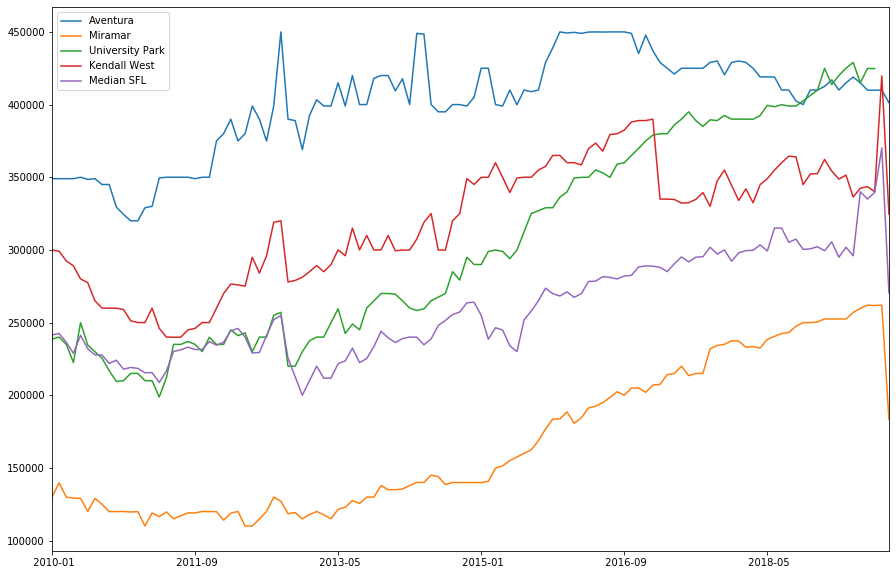

In [245]:
df_comparison = pd.concat([aventura, miramar, universitypark, kendallwest, median_prices], axis=1)
df_comparison.columns = ["Aventura", "Miramar", "University Park", "Kendall West", "Median SFL"]
df_comparison.plot(figsize=(15,10))

# Combine with census population data

In [247]:
pop_data.head()

zip_code   2016   2015   2014   2013   2012   2011   2010  aggregate
0       601  17800  17982  18088  18450  18544  18533  18570     127967
1       602  39716  40260  40859  41302  41640  41930  41520     287227
2       603  51565  52408  53162  53683  54540  54475  54689     374522
3       606   6320   6331   6415   6591   6593   6386   6615      45251
4       610  27976  28328  28805  28963  29141  29111  29016     201340

In [248]:
# Rotates table so dates are tuples rather than columns
pop_data = pop_data.melt(id_vars=["zip_code"], 
        var_name="Date", 
        value_name="Population")
pop_data.rename(columns={'zip_code':'ZipCode'}, inplace=True)
pop_data[:5]

ZipCode  Date  Population
0      601  2016       17800
1      602  2016       39716
2      603  2016       51565
3      606  2016        6320
4      610  2016       27976

In [249]:
pop_data['Date'] = pd.to_datetime(pop_data.Date, format='%Y', errors ='coerce')
pop_data

ZipCode       Date  Population
0           601 2016-01-01       17800
1           602 2016-01-01       39716
2           603 2016-01-01       51565
3           606 2016-01-01        6320
4           610 2016-01-01       27976
...         ...        ...         ...
264955    99923        NaT         386
264956    99925        NaT        5311
264957    99926        NaT       11202
264958    99927        NaT         682
264959    99929        NaT       16465

[264960 rows x 3 columns]

In [250]:
pop_data['Date'] = pop_data['Date'].dt.strftime('%Y')
pop_data

ZipCode  Date  Population
0           601  2016       17800
1           602  2016       39716
2           603  2016       51565
3           606  2016        6320
4           610  2016       27976
...         ...   ...         ...
264955    99923   NaT         386
264956    99925   NaT        5311
264957    99926   NaT       11202
264958    99927   NaT         682
264959    99929   NaT       16465

[264960 rows x 3 columns]

In [251]:
data_pop_year = data_clean
data_pop_year['Date'] = pd.to_datetime(data_clean['Date'])
data_pop_year['Date'] = data_clean['Date'].dt.strftime('%Y')
data_pop_year

Date  ZipCode            City State  \
0     2010    33019       Hollywood    FL   
1     2010    33023         Miramar    FL   
2     2010    33024  Pembroke Pines    FL   
3     2010    33028  Pembroke Pines    FL   
4     2010    33029  Pembroke Pines    FL   
...    ...      ...             ...   ...   
6994  2019    33182         Tamiami    FL   
6995  2019    33185    Kendall West    FL   
6996  2019    33189      Cutler Bay    FL   
6997  2019    33190      Cutler Bay    FL   
6998  2019    33196    The Hammocks    FL   

                                      Metro             County   Listing  \
0     Miami-Fort Lauderdale-West Palm Beach     Broward County  334894.5   
1     Miami-Fort Lauderdale-West Palm Beach     Broward County  129950.0   
2     Miami-Fort Lauderdale-West Palm Beach     Broward County  159900.0   
3     Miami-Fort Lauderdale-West Palm Beach     Broward County  320000.0   
4     Miami-Fort Lauderdale-West Palm Beach     Broward County  335000.0   
...                                     ...                ...       ...   
6994  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  395000.0   
6995  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  419654.5   
6996  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  319999.0   
6997  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  269900.0   
6998  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  369000.0   

        Sale  PercRedux  
0     191400       43.0  
1      89600       31.0  
2     121000       24.0  
3     280300       12.0  
4     270300       19.0  
...      ...        ...  
6994  321800       19.0  
6995  388200        7.0  
6996  308700        4.0  
6997  254700        6.0  
6998  319700       13.0  

[6999 rows x 9 columns]

In [252]:
data_clean_pop = pd.merge(data_pop_year, pop_data, on=['Date','ZipCode'], how='left')

In [253]:
data_clean_pop['Date'] = pd.to_datetime(data_clean_pop['Date'])
data_clean_pop['Date'] = data_clean_pop['Date'].dt.strftime('%Y')
data_clean_pop

Date  ZipCode            City State  \
0     2010    33019       Hollywood    FL   
1     2010    33023         Miramar    FL   
2     2010    33024  Pembroke Pines    FL   
3     2010    33028  Pembroke Pines    FL   
4     2010    33029  Pembroke Pines    FL   
...    ...      ...             ...   ...   
6994  2019    33182         Tamiami    FL   
6995  2019    33185    Kendall West    FL   
6996  2019    33189      Cutler Bay    FL   
6997  2019    33190      Cutler Bay    FL   
6998  2019    33196    The Hammocks    FL   

                                      Metro             County   Listing  \
0     Miami-Fort Lauderdale-West Palm Beach     Broward County  334894.5   
1     Miami-Fort Lauderdale-West Palm Beach     Broward County  129950.0   
2     Miami-Fort Lauderdale-West Palm Beach     Broward County  159900.0   
3     Miami-Fort Lauderdale-West Palm Beach     Broward County  320000.0   
4     Miami-Fort Lauderdale-West Palm Beach     Broward County  335000.0   
...                                     ...                ...       ...   
6994  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  395000.0   
6995  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  419654.5   
6996  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  319999.0   
6997  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  269900.0   
6998  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  369000.0   

        Sale  PercRedux  Population  
0     191400       43.0     15107.0  
1      89600       31.0     63576.0  
2     121000       24.0     63916.0  
3     280300       12.0     26696.0  
4     270300       19.0     45235.0  
...      ...        ...         ...  
6994  321800       19.0         NaN  
6995  388200        7.0         NaN  
6996  308700        4.0         NaN  
6997  254700        6.0         NaN  
6998  319700       13.0         NaN  

[6999 rows x 10 columns]

In [254]:
# No population data for 2017 and beyond, so drop
data_clean_pop = data_clean_pop[data_clean_pop['Date'] < '2017']
data_clean_pop

Date  ZipCode            City State  \
0     2010    33019       Hollywood    FL   
1     2010    33023         Miramar    FL   
2     2010    33024  Pembroke Pines    FL   
3     2010    33028  Pembroke Pines    FL   
4     2010    33029  Pembroke Pines    FL   
...    ...      ...             ...   ...   
5335  2016    33185    Kendall West    FL   
5336  2016    33186   The Crossings    FL   
5337  2016    33189      Cutler Bay    FL   
5338  2016    33190      Cutler Bay    FL   
5339  2016    33196    The Hammocks    FL   

                                      Metro             County   Listing  \
0     Miami-Fort Lauderdale-West Palm Beach     Broward County  334894.5   
1     Miami-Fort Lauderdale-West Palm Beach     Broward County  129950.0   
2     Miami-Fort Lauderdale-West Palm Beach     Broward County  159900.0   
3     Miami-Fort Lauderdale-West Palm Beach     Broward County  320000.0   
4     Miami-Fort Lauderdale-West Palm Beach     Broward County  335000.0   
...                                     ...                ...       ...   
5335  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  389000.0   
5336  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  285000.0   
5337  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  265000.0   
5338  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  229900.0   
5339  Miami-Fort Lauderdale-West Palm Beach  Miami-Dade County  330000.0   

        Sale  PercRedux  Population  
0     191400       43.0     15107.0  
1      89600       31.0     63576.0  
2     121000       24.0     63916.0  
3     280300       12.0     26696.0  
4     270300       19.0     45235.0  
...      ...        ...         ...  
5335  345500       11.0     30910.0  
5336  263900        7.0     70882.0  
5337  243800        8.0     26363.0  
5338  225900        2.0     14980.0  
5339  287800       13.0     48092.0  

[4037 rows x 10 columns]

In [255]:
data_clean_pop['Sale'].corr(data_clean_pop['Population'])

-0.41001030695422624

In [256]:
data_clean_pop['Listing'].corr(data_clean_pop['Population'])

-0.4207923385451208

Note: Moderate negative correlation between population and sale, and population and listing. Suggests overpopulation negatively impacts prices.

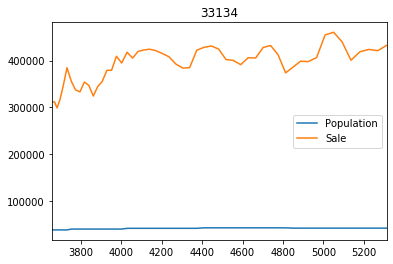

In [257]:
zipcode = 33134
data_clean_pop.loc[(data_clean_pop.ZipCode == zipcode),
                   ['Date','Population','Sale']].plot(title=zipcode)


# Tropical Disturbances' Effects on Prices

In [258]:
# Import storm data
storm_data.head()

EVENT_ID                       CZ_NAME_STR BEGIN_LOCATION  BEGIN_DATE  \
0    251890  COASTAL MIAMI-DADE COUNTY (ZONE)                 07/23/2010   
1    343546  COASTAL PALM BEACH COUNTY (ZONE)                 08/25/2011   
2    343537     COASTAL BROWARD COUNTY (ZONE)                 08/25/2011   
3    329852                      DUVAL (ZONE)                 08/25/2011   
4    329853                    FLAGLER (ZONE)                 08/26/2011   

   BEGIN_TIME      EVENT_TYPE MAGNITUDE TOR_F_SCALE  DEATHS_DIRECT  \
0         530  Tropical Storm                                    0   
1         730  Tropical Storm                                    0   
2        1400  Tropical Storm                                    0   
3        2000  Tropical Storm                                    0   
4        1552  Tropical Storm                                    0   

   INJURIES_DIRECT  ...  END_RANGE  END_AZIMUTH END_LOCATION BEGIN_LAT  \
0                0  ...                                                  
1                0  ...                                                  
2                0  ...                                                  
3                0  ...                                                  
4                0  ...                                                  

  BEGIN_LON  END_LAT END_LON  \
0                              
1                              
2                              
3                              
4                              

                                     EVENT_NARRATIVE  \
0  Tropical Storm Bonnie made landfall near Cutle...   
1  Winds to marginal tropical storm force and hig...   
2  Winds to marginal tropical storm force and hig...   
3  The first tropical storm wind gusts measured i...   
4  A spotter measured a wind gust of 41 mph in Fl...   

                                   EPISODE_NARRATIVE  ABSOLUTE_ROWNUMBER  
0  Tropical Storm Bonnie made landfall in Miami-D...                   1  
1  Hurricane Irene passed over the western Bahama...                   2  
2  Hurricane Irene passed over the western Bahama...                   3  
3  From the evening of 8/25 through the evening o...                   4  
4  From the evening of 8/25 through the evening o...                   5  

[5 rows x 37 columns]

In [215]:
storm_data['BEGIN_DATE'] = pd.to_datetime(storm_data['BEGIN_DATE'], format="%m/%d/%Y")
storm_data.rename(columns={'BEGIN_DATE':'Date'}, inplace=True)
storm_data.head()

EVENT_ID                       CZ_NAME_STR BEGIN_LOCATION       Date  \
0    251890  COASTAL MIAMI-DADE COUNTY (ZONE)                2010-07-23   
1    343546  COASTAL PALM BEACH COUNTY (ZONE)                2011-08-25   
2    343537     COASTAL BROWARD COUNTY (ZONE)                2011-08-25   
3    329852                      DUVAL (ZONE)                2011-08-25   
4    329853                    FLAGLER (ZONE)                2011-08-26   

   BEGIN_TIME      EVENT_TYPE MAGNITUDE TOR_F_SCALE  DEATHS_DIRECT  \
0         530  Tropical Storm                                    0   
1         730  Tropical Storm                                    0   
2        1400  Tropical Storm                                    0   
3        2000  Tropical Storm                                    0   
4        1552  Tropical Storm                                    0   

   INJURIES_DIRECT  ...  END_RANGE  END_AZIMUTH END_LOCATION BEGIN_LAT  \
0                0  ...                                                  
1                0  ...                                                  
2                0  ...                                                  
3                0  ...                                                  
4                0  ...                                                  

  BEGIN_LON  END_LAT END_LON  \
0                              
1                              
2                              
3                              
4                              

                                     EVENT_NARRATIVE  \
0  Tropical Storm Bonnie made landfall near Cutle...   
1  Winds to marginal tropical storm force and hig...   
2  Winds to marginal tropical storm force and hig...   
3  The first tropical storm wind gusts measured i...   
4  A spotter measured a wind gust of 41 mph in Fl...   

                                   EPISODE_NARRATIVE  ABSOLUTE_ROWNUMBER  
0  Tropical Storm Bonnie made landfall in Miami-D...                   1  
1  Hurricane Irene passed over the western Bahama...                   2  
2  Hurricane Irene passed over the western Bahama...                   3  
3  From the evening of 8/25 through the evening o...                   4  
4  From the evening of 8/25 through the evening o...                   5  

[5 rows x 37 columns]

In [216]:
storm_data_count = storm_data.groupby('Date')['CZ_NAME_STR'].count().reset_index()
storm_data_count.rename(columns={'CZ_NAME_STR':'StormCount'}, inplace=True)
storm_data_count.head()

Date  StormCount
0 2010-07-23           1
1 2011-08-25           3
2 2011-08-26           1
3 2012-05-27           3
4 2012-05-28           3

In [217]:
storm_data_count['Date'] = pd.to_datetime(storm_data_count['Date'])
storm_data_count['Date'] = storm_data_count['Date'].dt.strftime('%Y-%m')
storm_data_count = storm_data_count.groupby('Date')['StormCount'].sum().reset_index()
storm_data_count.head()

Date  StormCount
0  2010-07           1
1  2011-08           4
2  2012-05           6
3  2012-06          20
4  2012-08          20

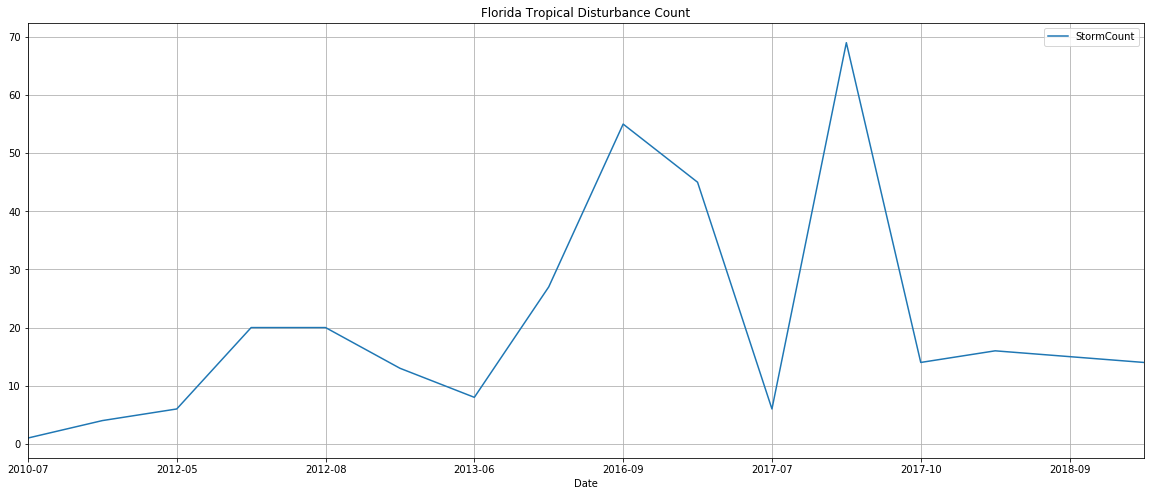

In [218]:
storm_data_count[['Date','StormCount']].plot('Date', figsize=(20,8), grid=True, title="Florida Tropical Disturbance Count")

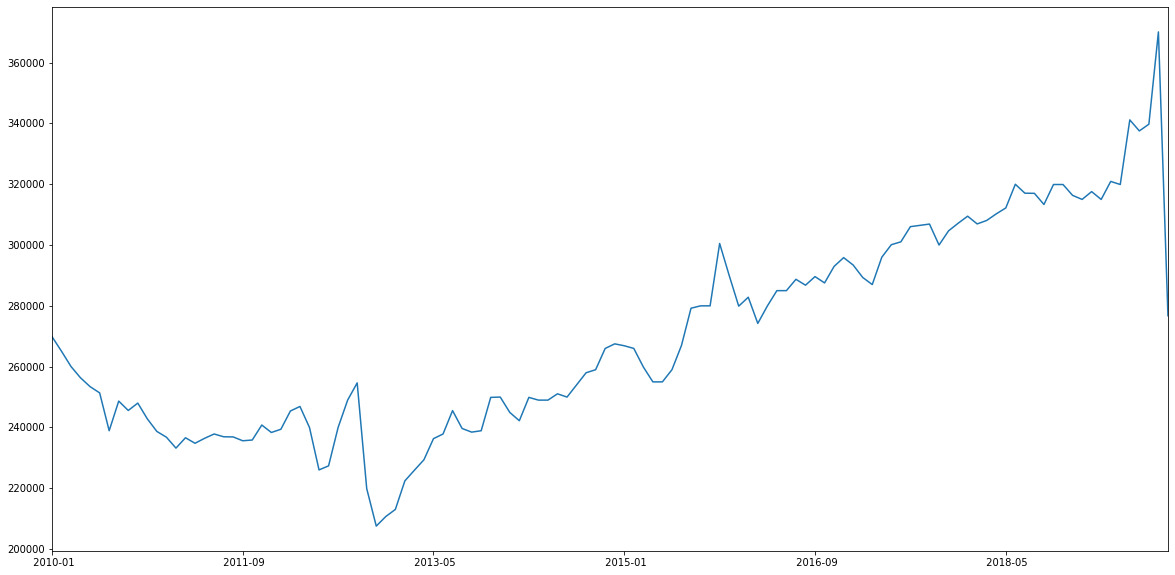

In [80]:
median_prices.plot(figsize=(20,10))

In [81]:
price = pd.DataFrame(median_prices)
price.columns = ['Price']
price = price.reset_index()

In [82]:
price.head()

index          Price
0   2010-01  269900.000000
1   2010-02  265074.424242
2   2010-03  260034.651515
3   2010-04  256314.575758
4   2010-05  253425.681818

In [83]:
price['Price'].corr(storm_data_count['StormCount'])

-0.2984934632771363

Note: There is a relatively weak negative correlation between number of storm disturbances and median house price. While more storms may negatively affect pricing, people generally understand Florida gets hurricanes along with year-round summers.

# Use land-water ratio for each zip code to assess effects of closeness to bodies of water's effect on price

In [84]:
census_data.columns

Index(['UID', 'BLOCKID', 'SUMLEVEL', 'COUNTYID', 'STATEID', 'state',
       'state_ab', 'city', 'place', 'type', 'primary', 'zip_code', 'area_code',
       'lat', 'lng', 'ALand', 'AWater', 'pop', 'male_pop', 'female_pop',
       'rent_mean', 'rent_median', 'rent_stdev', 'rent_sample_weight',
       'rent_samples', 'rent_gt_10', 'rent_gt_15', 'rent_gt_20', 'rent_gt_25',
       'rent_gt_30', 'rent_gt_35', 'rent_gt_40', 'rent_gt_50',
       'universe_samples', 'used_samples', 'hi_mean', 'hi_median', 'hi_stdev',
       'hi_sample_weight', 'hi_samples', 'family_mean', 'family_median',
       'family_stdev', 'family_sample_weight', 'family_samples',
       'hc_mortgage_mean', 'hc_mortgage_median', 'hc_mortgage_stdev',
       'hc_mortgage_sample_weight', 'hc_mortgage_samples', 'hc_mean',
       'hc_median', 'hc_stdev', 'hc_samples', 'hc_sample_weight',
       'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'debt',
       'second_mortgage_cdf', 'home_equity_cdf', 'debt_cdf', '

In [85]:
landwater_data = census_data.loc[census_data['state_ab'].str.contains('FL'), ['zip_code', 'place','city', 'state', 'ALand', 'AWater']]
landwater_data.head()

zip_code             place         city    state    ALand  AWater
54747     32601  Gainesville City  Gainesville  Florida  2096008       0
54748     32601  Gainesville City  Gainesville  Florida  2479035   22169
54749     32609  Gainesville City  Gainesville  Florida  3793940   39594
54750     32609  Gainesville City  Gainesville  Florida  6020171    9011
54751     32601  Gainesville City  Gainesville  Florida  3912763    1068

In [86]:
landwater_data = landwater_data.groupby(['zip_code', 'place', 'city',
                                         'state'])['ALand', 'AWater'].sum().reset_index()
landwater_data.head()

zip_code           place            city    state       ALand    AWater
0     32003  Fleming Island  Fleming Island  Florida   103263810   3100365
1     32003  Fleming Island     Orange Park  Florida   130181496  87739418
2     32006        Lakeside  Fleming Island  Florida    41949145  15585040
3     32008        Branford        Branford  Florida  1742091885   9209945
4     32009         Baldwin      Bryceville  Florida   890074305    406179

In [87]:
# Note zip code arrays: MiamiDadeCounty_ZipCodes and BrowardCounty_ZipCodes
landwater_data_zip = landwater_data.groupby(['zip_code'])['ALand', 'AWater'].sum().reset_index()
landwater_data_zip.head()

zip_code       ALand    AWater
0     32003   233445306  90839783
1     32006    41949145  15585040
2     32008  1742091885   9209945
3     32009   890074305    406179
4     32011   911259780     71652

In [88]:
landwater_data_zip['land-water'] = landwater_data_zip['ALand'] / landwater_data_zip['AWater']
landwater_data_zip.head()

zip_code       ALand    AWater    land-water
0     32003   233445306  90839783      2.569858
1     32006    41949145  15585040      2.691629
2     32008  1742091885   9209945    189.153343
3     32009   890074305    406179   2191.335113
4     32011   911259780     71652  12717.855468

# Land-Water Ratio for Miami-Dade County

Does proximity to water affect pricing?

In [89]:
landwater_data_mdc = landwater_data_zip[landwater_data_zip.zip_code.isin(MiamiDadeCounty_ZipCodes)]
landwater_data_mdc.head()

zip_code     ALand   AWater  land-water
309     33010  23700874    26950  879.438738
310     33012  57796776  2863803   20.181827
311     33013  63167480  2068737   30.534321
312     33014  52163065  7154725    7.290716
313     33015  72200045  6140162   11.758655

In [90]:
landwater_data_mdc.rename(columns={'zip_code':'ZipCode'}, inplace=True)

/Users/rogerjimenez/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


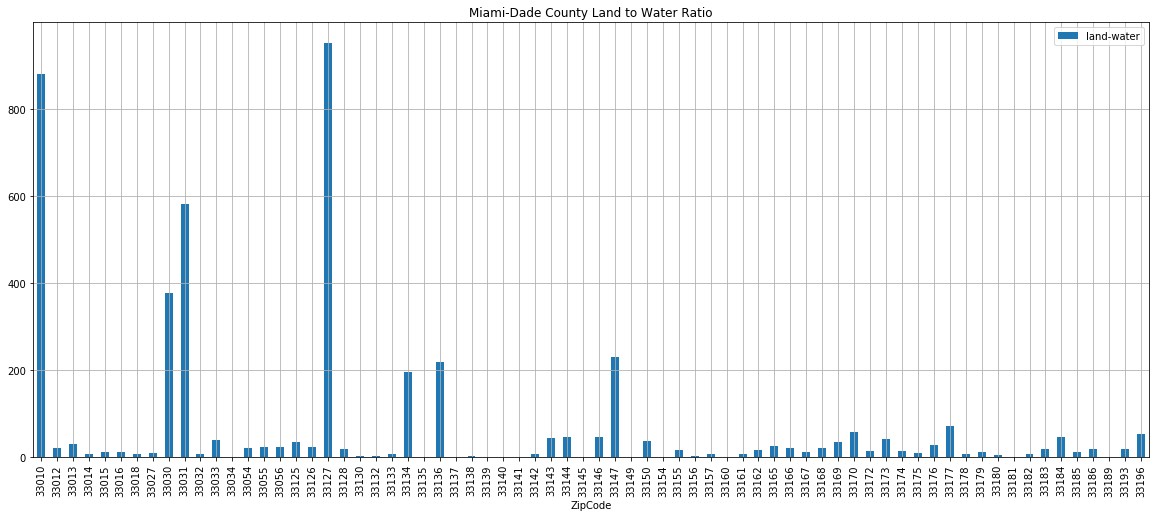

In [91]:
landwater_data_mdc[['ZipCode','land-water']].plot('ZipCode', figsize=(20,8), grid=True, 
                                               title='Miami-Dade County Land to Water Ratio', kind='bar')

In [92]:
data_miami_2018 = data_2018[data_2018.ZipCode.isin(MiamiDadeCounty_ZipCodes)]
data_miami_2018 = data_miami_2018.groupby(['ZipCode'])['Listing', 'Sale'].sum()
data_miami_2018.head()

Listing     Sale
ZipCode                    
33010    3209750.0  2972300
33012     844500.0   614200
33013    3793150.0  3300800
33014    3382863.0  2741400
33015    2790698.5  2605700

In [93]:
data_miami_2018 = data_miami_2018.merge(landwater_data_mdc, on='ZipCode', how='left')
data_miami_2018.head()

ZipCode    Listing     Sale       ALand     AWater  land-water
0    33010  3209750.0  2972300  23700874.0    26950.0  879.438738
1    33012   844500.0   614200  57796776.0  2863803.0   20.181827
2    33013  3793150.0  3300800  63167480.0  2068737.0   30.534321
3    33014  3382863.0  2741400  52163065.0  7154725.0    7.290716
4    33015  2790698.5  2605700  72200045.0  6140162.0   11.758655

In [94]:
# How is closeness to water correlated with listing price?
data_miami_2018['Listing'].corr(data_miami_2018['land-water'])

-0.03602580074676023

In [95]:
# How is closeness to water correlated with listing price?
data_miami_2018['Sale'].corr(data_miami_2018['land-water'])

-0.05470621910755564

Very weak negative correlation for Miami-Dade County. We should dismiss as insignificant.

# Land-Water Ratio for Broward County

In [96]:
landwater_data_bc = landwater_data_zip[landwater_data_zip.zip_code.isin(BrowardCounty_ZipCodes)]
landwater_data_bc.head()

zip_code      ALand    AWater  land-water
307     33004   89472571  23887205    3.745627
308     33009   33517412   2724042   12.304293
316     33020   93950936   7542252   12.456616
317     33021   77808129    434659  179.009589
318     33023  108137500   2207702   48.981928

In [97]:
landwater_data_bc.rename(columns={'zip_code':'ZipCode'}, inplace=True)

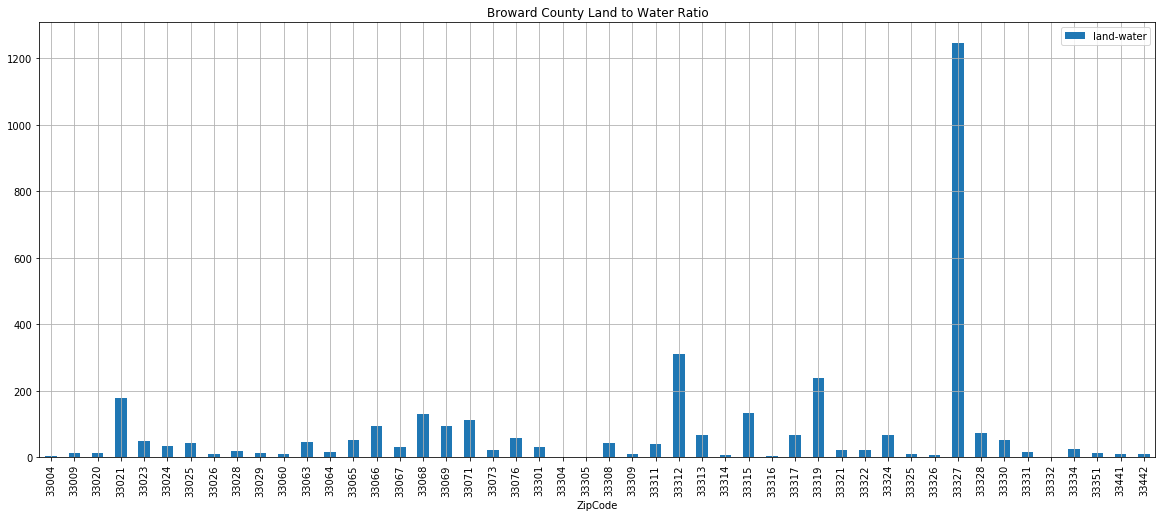

In [98]:
landwater_data_bc[['ZipCode','land-water']].plot('ZipCode', figsize=(20,8), grid=True, 
                                               title='Broward County Land to Water Ratio', kind='bar')

# Granular Property Data

In [99]:
property_data.head()

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
0 -80.203850  25.771201       MIAMI BEACH               33130          N   
1 -80.203701  25.771206             MIAMI               33130          N   
2 -80.203543  25.771211             MIAMI               33130          N   
3 -80.203389  25.771215       MIAMI LAKES               33130          N   
4 -80.203238  25.771220             MIAMI               33130          N   

   BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
0            3.0            13.0                  0.0          2.0   
1           12.0             7.0                  0.0          2.0   
2            9.0             3.0                  0.0          2.0   
3           12.0             6.0                  0.0          2.0   
4            4.0             3.0                  0.0          2.0   

   UNIT_COUNT  BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA  LOT_SIZE  \
0        13.0                4872.0                6192.0    7500.0   
1         5.0                4169.0                4169.0    7500.0   
2         1.0                3370.0                3370.0    7500.0   
3         6.0                4060.0                4060.0    7500.0   
4         3.0                2133.0                2577.0    7500.0   

   YEAR_BUILT  ASSESSMENT_YEAR_CUR  ASSESSED_VAL_CUR    PRICE_1  \
0      1911.0               2020.0         1056000.0  1315000.0   
1      1979.0               2020.0          535766.0   855000.0   
2      1935.0               2020.0          279956.0      100.0   
3      1973.0               2020.0          430700.0   225000.0   
4      1910.0               2020.0          364016.0      100.0   

             DATEOFSALE_UTC  
0  2018-04-12T04:00:00.000Z  
1  2016-02-05T05:00:00.000Z  
2  2011-05-16T04:00:00.000Z  
3  1999-12-01T05:00:00.000Z  
4  2019-05-01T04:00:00.000Z

In [100]:
property_data['PPSF'] = property_data['PRICE_1'] / property_data['BUILDING_ACTUAL_AREA']
property_data['PP_Lot'] = property_data['PRICE_1'] / property_data['LOT_SIZE']
property_data['PP_bed'] = property_data['PRICE_1'] / property_data['BEDROOM_COUNT']
property_data['PP_bath'] = property_data['PRICE_1'] / property_data['BATHROOM_COUNT']
property_data.head()

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
0 -80.203850  25.771201       MIAMI BEACH               33130          N   
1 -80.203701  25.771206             MIAMI               33130          N   
2 -80.203543  25.771211             MIAMI               33130          N   
3 -80.203389  25.771215       MIAMI LAKES               33130          N   
4 -80.203238  25.771220             MIAMI               33130          N   

   BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
0            3.0            13.0                  0.0          2.0   
1           12.0             7.0                  0.0          2.0   
2            9.0             3.0                  0.0          2.0   
3           12.0             6.0                  0.0          2.0   
4            4.0             3.0                  0.0          2.0   

   UNIT_COUNT  ...  LOT_SIZE  YEAR_BUILT  ASSESSMENT_YEAR_CUR  \
0        13.0  ...    7500.0      1911.0               2020.0   
1         5.0  ...    7500.0      1979.0               2020.0   
2         1.0  ...    7500.0      1935.0               2020.0   
3         6.0  ...    7500.0      1973.0               2020.0   
4         3.0  ...    7500.0      1910.0               2020.0   

   ASSESSED_VAL_CUR    PRICE_1            DATEOFSALE_UTC        PPSF  \
0         1056000.0  1315000.0  2018-04-12T04:00:00.000Z  269.909688   
1          535766.0   855000.0  2016-02-05T05:00:00.000Z  205.085152   
2          279956.0      100.0  2011-05-16T04:00:00.000Z    0.029674   
3          430700.0   225000.0  1999-12-01T05:00:00.000Z   55.418719   
4          364016.0      100.0  2019-05-01T04:00:00.000Z    0.046882   

       PP_Lot         PP_bed        PP_bath  
0  175.333333  438333.333333  101153.846154  
1  114.000000   71250.000000  122142.857143  
2    0.013333      11.111111      33.333333  
3   30.000000   18750.000000   37500.000000  
4    0.013333      25.000000      33.333333  

[5 rows x 22 columns]

In [101]:
property_data = property_data[property_data['PPSF'] > 10]
property_data.head()

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
0 -80.203850  25.771201       MIAMI BEACH               33130          N   
1 -80.203701  25.771206             MIAMI               33130          N   
3 -80.203389  25.771215       MIAMI LAKES               33130          N   
5 -80.202936  25.771329             MIAMI               33130          N   
6 -80.204545  25.771716             MIAMI               33130          N   

   BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
0            3.0            13.0                  0.0          2.0   
1           12.0             7.0                  0.0          2.0   
3           12.0             6.0                  0.0          2.0   
5           60.0            23.0                  0.0          3.0   
6            8.0             4.0                  0.0          2.0   

   UNIT_COUNT  ...  LOT_SIZE  YEAR_BUILT  ASSESSMENT_YEAR_CUR  \
0        13.0  ...    7500.0      1911.0               2020.0   
1         5.0  ...    7500.0      1979.0               2020.0   
3         6.0  ...    7500.0      1973.0               2020.0   
5        59.0  ...   11250.0      1924.0               2020.0   
6         4.0  ...    5000.0      1999.0               2020.0   

   ASSESSED_VAL_CUR    PRICE_1            DATEOFSALE_UTC        PPSF  \
0         1056000.0  1315000.0  2018-04-12T04:00:00.000Z  269.909688   
1          535766.0   855000.0  2016-02-05T05:00:00.000Z  205.085152   
3          430700.0   225000.0  1999-12-01T05:00:00.000Z   55.418719   
5          827291.0   375000.0  2001-04-01T04:00:00.000Z   23.711666   
6          394010.0   280000.0  2011-09-28T04:00:00.000Z  109.846999   

       PP_Lot         PP_bed        PP_bath  
0  175.333333  438333.333333  101153.846154  
1  114.000000   71250.000000  122142.857143  
3   30.000000   18750.000000   37500.000000  
5   33.333333    6250.000000   16304.347826  
6   56.000000   35000.000000   70000.000000  

[5 rows x 22 columns]

In [102]:
property_data.dtypes

X                       float64
Y                       float64
TRUE_MAILING_CITY        object
TRUE_SITE_ZIP_CODE        int64
CONDO_FLAG               object
BEDROOM_COUNT           float64
BATHROOM_COUNT          float64
HALF_BATHROOM_COUNT     float64
FLOOR_COUNT             float64
UNIT_COUNT              float64
BUILDING_ACTUAL_AREA    float64
BUILDING_HEATED_AREA    float64
LOT_SIZE                float64
YEAR_BUILT              float64
ASSESSMENT_YEAR_CUR     float64
ASSESSED_VAL_CUR        float64
PRICE_1                 float64
DATEOFSALE_UTC           object
PPSF                    float64
PP_Lot                  float64
PP_bed                  float64
PP_bath                 float64
dtype: object

In [103]:
property_data['DATEOFSALE_UTC'] = pd.to_datetime(property_data['DATEOFSALE_UTC'])
property_data.head()

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
0 -80.203850  25.771201       MIAMI BEACH               33130          N   
1 -80.203701  25.771206             MIAMI               33130          N   
3 -80.203389  25.771215       MIAMI LAKES               33130          N   
5 -80.202936  25.771329             MIAMI               33130          N   
6 -80.204545  25.771716             MIAMI               33130          N   

   BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
0            3.0            13.0                  0.0          2.0   
1           12.0             7.0                  0.0          2.0   
3           12.0             6.0                  0.0          2.0   
5           60.0            23.0                  0.0          3.0   
6            8.0             4.0                  0.0          2.0   

   UNIT_COUNT  ...  LOT_SIZE  YEAR_BUILT  ASSESSMENT_YEAR_CUR  \
0        13.0  ...    7500.0      1911.0               2020.0   
1         5.0  ...    7500.0      1979.0               2020.0   
3         6.0  ...    7500.0      1973.0               2020.0   
5        59.0  ...   11250.0      1924.0               2020.0   
6         4.0  ...    5000.0      1999.0               2020.0   

   ASSESSED_VAL_CUR    PRICE_1            DATEOFSALE_UTC        PPSF  \
0         1056000.0  1315000.0 2018-04-12 04:00:00+00:00  269.909688   
1          535766.0   855000.0 2016-02-05 05:00:00+00:00  205.085152   
3          430700.0   225000.0 1999-12-01 05:00:00+00:00   55.418719   
5          827291.0   375000.0 2001-04-01 04:00:00+00:00   23.711666   
6          394010.0   280000.0 2011-09-28 04:00:00+00:00  109.846999   

       PP_Lot         PP_bed        PP_bath  
0  175.333333  438333.333333  101153.846154  
1  114.000000   71250.000000  122142.857143  
3   30.000000   18750.000000   37500.000000  
5   33.333333    6250.000000   16304.347826  
6   56.000000   35000.000000   70000.000000  

[5 rows x 22 columns]

In [104]:
property_data = property_data.drop('ASSESSMENT_YEAR_CUR', 1)
property_data = property_data.drop('ASSESSED_VAL_CUR', 1)
property_data.head()

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
0 -80.203850  25.771201       MIAMI BEACH               33130          N   
1 -80.203701  25.771206             MIAMI               33130          N   
3 -80.203389  25.771215       MIAMI LAKES               33130          N   
5 -80.202936  25.771329             MIAMI               33130          N   
6 -80.204545  25.771716             MIAMI               33130          N   

   BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
0            3.0            13.0                  0.0          2.0   
1           12.0             7.0                  0.0          2.0   
3           12.0             6.0                  0.0          2.0   
5           60.0            23.0                  0.0          3.0   
6            8.0             4.0                  0.0          2.0   

   UNIT_COUNT  BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA  LOT_SIZE  \
0        13.0                4872.0                6192.0    7500.0   
1         5.0                4169.0                4169.0    7500.0   
3         6.0                4060.0                4060.0    7500.0   
5        59.0               15815.0               15815.0   11250.0   
6         4.0                2549.0                2549.0    5000.0   

   YEAR_BUILT    PRICE_1            DATEOFSALE_UTC        PPSF      PP_Lot  \
0      1911.0  1315000.0 2018-04-12 04:00:00+00:00  269.909688  175.333333   
1      1979.0   855000.0 2016-02-05 05:00:00+00:00  205.085152  114.000000   
3      1973.0   225000.0 1999-12-01 05:00:00+00:00   55.418719   30.000000   
5      1924.0   375000.0 2001-04-01 04:00:00+00:00   23.711666   33.333333   
6      1999.0   280000.0 2011-09-28 04:00:00+00:00  109.846999   56.000000   

          PP_bed        PP_bath  
0  438333.333333  101153.846154  
1   71250.000000  122142.857143  
3   18750.000000   37500.000000  
5    6250.000000   16304.347826  
6   35000.000000   70000.000000

In [105]:
property_data['DATEOFSALE_UTC'] = property_data['DATEOFSALE_UTC'].dt.strftime('%Y-%m')
property_data.head()

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
0 -80.203850  25.771201       MIAMI BEACH               33130          N   
1 -80.203701  25.771206             MIAMI               33130          N   
3 -80.203389  25.771215       MIAMI LAKES               33130          N   
5 -80.202936  25.771329             MIAMI               33130          N   
6 -80.204545  25.771716             MIAMI               33130          N   

   BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
0            3.0            13.0                  0.0          2.0   
1           12.0             7.0                  0.0          2.0   
3           12.0             6.0                  0.0          2.0   
5           60.0            23.0                  0.0          3.0   
6            8.0             4.0                  0.0          2.0   

   UNIT_COUNT  BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA  LOT_SIZE  \
0        13.0                4872.0                6192.0    7500.0   
1         5.0                4169.0                4169.0    7500.0   
3         6.0                4060.0                4060.0    7500.0   
5        59.0               15815.0               15815.0   11250.0   
6         4.0                2549.0                2549.0    5000.0   

   YEAR_BUILT    PRICE_1 DATEOFSALE_UTC        PPSF      PP_Lot  \
0      1911.0  1315000.0        2018-04  269.909688  175.333333   
1      1979.0   855000.0        2016-02  205.085152  114.000000   
3      1973.0   225000.0        1999-12   55.418719   30.000000   
5      1924.0   375000.0        2001-04   23.711666   33.333333   
6      1999.0   280000.0        2011-09  109.846999   56.000000   

          PP_bed        PP_bath  
0  438333.333333  101153.846154  
1   71250.000000  122142.857143  
3   18750.000000   37500.000000  
5    6250.000000   16304.347826  
6   35000.000000   70000.000000

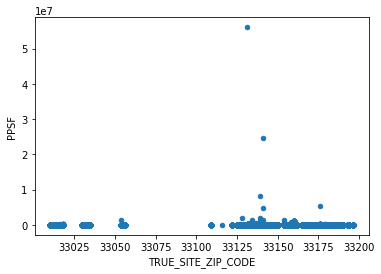

In [106]:
property_data.plot(kind = 'scatter', x = 'TRUE_SITE_ZIP_CODE', y = 'PPSF')

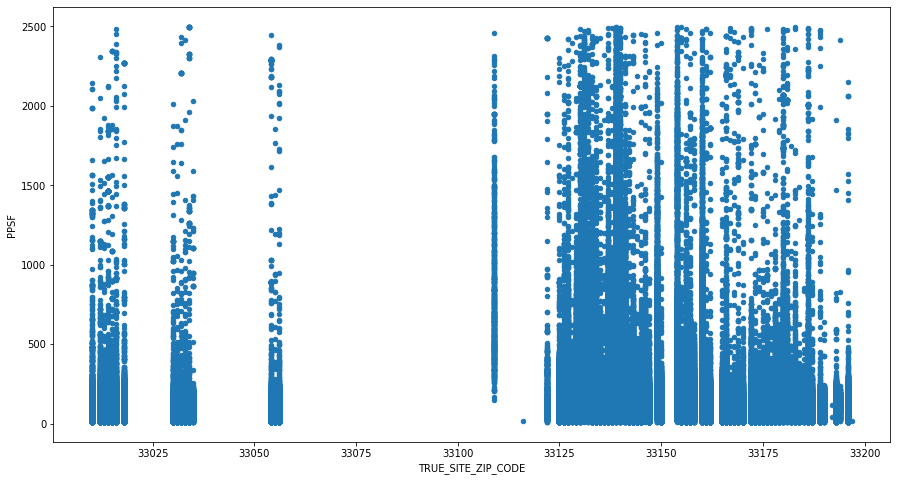

In [107]:
property_data = property_data[property_data['PPSF'] < 2500]
property_data.plot(kind = 'scatter', x = 'TRUE_SITE_ZIP_CODE', y = 'PPSF', figsize = (15, 8))

In [108]:
property_data_2019 = property_data[(property_data['DATEOFSALE_UTC'] > '2019-01') & (property_data['DATEOFSALE_UTC'] < '2020-1')]
property_data_2018 = property_data[(property_data['DATEOFSALE_UTC'] > '2018-01') & (property_data['DATEOFSALE_UTC'] < '2019-1')]
property_data_2017 = property_data[(property_data['DATEOFSALE_UTC'] > '2017-01') & (property_data['DATEOFSALE_UTC'] < '2018-1')]
property_data_2016 = property_data[(property_data['DATEOFSALE_UTC'] > '2016-01') & (property_data['DATEOFSALE_UTC'] < '2017-1')]
property_data_2015 = property_data[(property_data['DATEOFSALE_UTC'] > '2015-01') & (property_data['DATEOFSALE_UTC'] < '2016-1')]
property_data_2014 = property_data[(property_data['DATEOFSALE_UTC'] > '2014-01') & (property_data['DATEOFSALE_UTC'] < '2015-1')]
property_data_2013 = property_data[(property_data['DATEOFSALE_UTC'] > '2013-01') & (property_data['DATEOFSALE_UTC'] < '2014-1')]
property_data_2012 = property_data[(property_data['DATEOFSALE_UTC'] > '2012-01') & (property_data['DATEOFSALE_UTC'] < '2013-1')]
property_data_2011 = property_data[(property_data['DATEOFSALE_UTC'] > '2011-01') & (property_data['DATEOFSALE_UTC'] < '2012-1')]
property_data_2010 = property_data[(property_data['DATEOFSALE_UTC'] > '2010-01') & (property_data['DATEOFSALE_UTC'] < '2011-1')]

In [109]:
property_data_2019

X          Y TRUE_MAILING_CITY  TRUE_SITE_ZIP_CODE CONDO_FLAG  \
20     -80.205344  25.771150      KEY BISCAYNE               33130          N   
65     -80.202813  25.770130             MIAMI               33130          N   
66     -80.201234  25.770796             MIAMI               33130          N   
90     -80.200654  25.769773             MIAMI               33130          N   
141    -80.204456  25.769324             MIAMI               33130          N   
...           ...        ...               ...                 ...        ...   
888272 -80.383606  25.824617             DORAL               33178          Y   
888280 -80.383606  25.824617             DORAL               33178          Y   
888281 -80.383606  25.824617             DORAL               33178          Y   
888291 -80.383606  25.824617             DORAL               33178          Y   
888303 -80.383606  25.824617             MIAMI               33178          Y   

        BEDROOM_COUNT  BATHROOM_COUNT  HALF_BATHROOM_COUNT  FLOOR_COUNT  \
20               12.0             6.0                  0.0          2.0   
65               29.0            29.0                  0.0          3.0   
66               14.0            14.0                  0.0          3.0   
90               18.0            18.0                  0.0          1.0   
141              13.0            13.0                  0.0          1.0   
...               ...             ...                  ...          ...   
888272            2.0             2.0                  0.0          0.0   
888280            2.0             2.0                  1.0          0.0   
888281            2.0             2.0                  1.0          0.0   
888291            3.0             2.0                  0.0          0.0   
888303            2.0             2.0                  1.0          0.0   

        UNIT_COUNT  BUILDING_ACTUAL_AREA  BUILDING_HEATED_AREA  LOT_SIZE  \
20             6.0                3926.0                3926.0    7500.0   
65            29.0               13170.0               13170.0    5000.0   
66            14.0               11753.0               11753.0   15000.0   
90            18.0                8503.0                8503.0   15000.0   
141           13.0                3531.0                3531.0   10000.0   
...            ...                   ...                   ...       ...   
888272         1.0                1050.0                1050.0       0.0   
888280         1.0                1150.0                1150.0       0.0   
888281         1.0                1150.0                1150.0       0.0   
888291         1.0                1620.0                1620.0       0.0   
888303         1.0                1150.0                1150.0       0.0   

        YEAR_BUILT    PRICE_1 DATEOFSALE_UTC        PPSF      PP_Lot  \
20          1972.0  1035000.0        2019-06  263.627101  138.000000   
65          1929.0  2250000.0        2019-05  170.842825  450.000000   
66          1972.0  2850000.0        2019-03  242.491279  190.000000   
90          1960.0  2857000.0        2019-03  335.999059  190.466667   
141         1948.0  1150000.0        2019-05  325.686774  115.000000   
...            ...        ...            ...         ...         ...   
888272      2000.0   245000.0        2019-04  233.333333         inf   
888280      2000.0   221000.0        2019-03  192.173913         inf   
888281      2000.0   244000.0        2019-06  212.173913         inf   
888291      2000.0   265000.0        2019-05  163.580247         inf   
888303      2000.0   247500.0        2019-02  215.217391         inf   

               PP_bed        PP_bath  
20       86250.000000  172500.000000  
65       77586.206897   77586.206897  
66      203571.428571  203571.428571  
90      158722.222222  158722.222222  
141      88461.538462   88461.538462  
...               ...            ...  
888272  122500.000000  122500.000000  
888280  110500.000000  110500.000000  
888281  12200

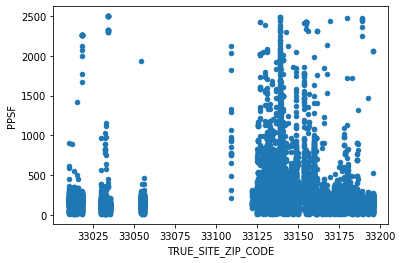

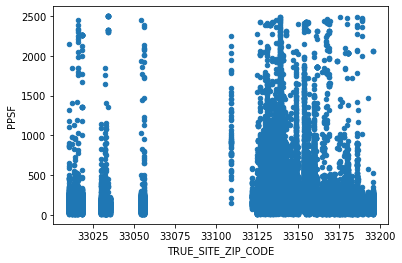

In [110]:
property_data_2019.plot(kind = 'scatter', x = 'TRUE_SITE_ZIP_CODE', y = 'PPSF')
property_data_2018.plot(kind = 'scatter', x = 'TRUE_SITE_ZIP_CODE', y = 'PPSF')

In [111]:
corr_area = property_data['PRICE_1'].corr(property_data['BUILDING_ACTUAL_AREA'])
corr_lot = property_data['PRICE_1'].corr(property_data['LOT_SIZE'])
corr_bed = property_data['PRICE_1'].corr(property_data['BEDROOM_COUNT'])
corr_bath = property_data['PRICE_1'].corr(property_data['BATHROOM_COUNT'])
print('Correlation between price and living area: %f' % corr_area)
print('Correlation between price and lot size: %f' % corr_lot)
print('Correlation between price and bedroom count: %f' % corr_bed)
print('Correlation between price and bathroom count: %f' % corr_bath)

Correlation between price and living area: 0.636817
Correlation between price and lot size: 0.087257
Correlation between price and bedroom count: 0.209296
Correlation between price and bathroom count: 0.237312


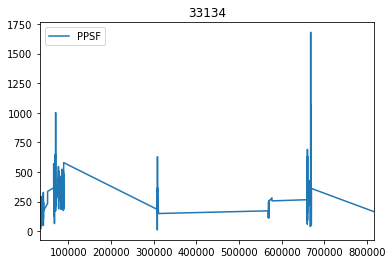

In [112]:
property_data_2019.loc[(property_data_2019.TRUE_SITE_ZIP_CODE == zipcode),
                   ['PPSF']].plot(title=zipcode)